# Introduction

This notebook implements Differential Evolution with Novel Parameter Control (DE-NPC) proposed by Meng et al. (2020) [1]. 

Using DE-NPC and MNIST [2], an adversarial image is generated. The prediction of an RBF Network on the adversarial image and original image is displayed.

[1] Meng, Z., Chen, Y., & Li, X. (2020). Enhancing differential evolution with novel parametercontrol. IEEE Access,8, 51145–51167. \\
[2] LeCun, Y., Cortes, C., & Burges, C.  (2010). MNIST handwritten digit database.



- statistical independence tests
- rerun the code?

# Libraries

In [1]:
%matplotlib inline
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import to_categorical
import tensorflow as tf
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, Activation
from keras.models import Model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from scipy.stats import cauchy 
from scipy import stats
import time
import operator
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from keras.models import load_model
from skimage.measure import compare_ssim as ssim
import pickle

#Set seeds
random.seed(0)
np.random.seed(0)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# DE_NPC Class

In [0]:
#https://www.geeksforgeeks.org/python-peak-signal-to-noise-ratio-psnr/
from math import log10, sqrt 
import cv2 
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 

In [0]:
# https://stackoverflow.com/questions/1401712/how-can-the-euclidean-distance-be-calculated-with-numpy
def euclidean(s):
    # pass s=a-b as argument to the function
    return np.linalg.norm(s)

In [0]:
class DE_NPC:
  def __init__(self,param_dict):
    ###Load Params##
    self.img = param_dict["input"]
    self.imsize = param_dict["input_size"]
    self.imclass = param_dict["imclass"]
    self.mean = param_dict["mean"]
    self.std = param_dict["std"]
    self.R_min = param_dict["R_min"]
    self.R_max = param_dict["R_max"]
    self.nfe_max = param_dict["nfe_max"]
    self.PS_ini = param_dict["PS_ini"]
    self.PS_min = param_dict["PS_min"]
    self.K = param_dict["K"]
    self.rarc = param_dict["rarc"]
    self.p = param_dict["p"]
    self.model = param_dict["model"]

    ####Initialize Params####
    self.set_params()

  #Fitness function
  def fitness_func(self,individual):
    individual = individual.reshape(1,int(np.sqrt(self.imsize)),int(np.sqrt(self.imsize)),1)
    pred = self.model.predict(individual  / 255.0)
    pred = pred[0]
    po = pred[self.imclass]
    pred[self.imclass] = 0
    pd = np.max(pred)
    diff = pd-po
    return (0.5)*diff + (-0.5)*euclidean(individual-self.img.reshape(1,self.imsize))/(self.imsize*255) 

  #Given the population and img(whihc is necessary to calculate the fitness function)
  #choose one individual whose fitness value is in top p percent.
  def get_top_p(self,PS,p):
    num_best = int(PS*p)
    fitness =  [(individual,self.fitness_func(individual)) for individual in self.population[0:PS]]
    fitness.sort(key=lambda x: x[1])
    fitness = fitness[-num_best:]
    return random.choice(fitness)[0]

  def execute(self, model):
    not_improving = 0
    nfe = 0
    PS = self.PS_ini
    A_ind = 0
    G = 1
    start = time.time()
    while nfe < self.nfe_max:
      #############################INITIALIZATION###################################
      #Sets of successfull f and cr values
      #with the corresponding weights
      s_f = [[] for i in range(self.K)]
      s_f_weights = [[] for i in range(self.K)]
      s_cr = [[] for i in range(self.K)]
      s_cr_weights = [[] for i in range(self.K)]
      #the selected k values for this iteration
      k_selections = np.zeros((self.K,PS))
      #how many times the specific k value was a success/failure
      k_success = np.zeros((self.K,1))
      k_failure = np.zeros((self.K,1))

      ####################ADJUST POPULATION AND A###################################
      #Adjustment done due to keep the individuals' values in range.
      #and to reduce the array sizes. However, even if the population size gets 
      #smaller than PS, since the loops are in range(PS), the individuals stored in 
      #the population vector in indices > PS will not be reached. 
      #Instead of picking discarded individuals randomly, we shuffle the population
      #and archive array. It should amount to picking random.
      if G > 2:
        #Adjust the individuals of the population; 
        for i in range(PS):
          self.population[i] = np.clip(self.population[i], self.R_min, self.R_max).reshape(self.imsize)
        #Adjust storage A; 
        for i in range(self.A_size):
          self.A[i] = np.clip(self.A[i], self.R_min, self.R_max).reshape(self.imsize)
        np.random.shuffle(self.A)
        np.random.shuffle(self.population)

      #############################SELECT K,F,CR'S##################################  
      #We select a k value for each individual in the population
      #with respect to the selection probabilities (p_k) of each k.
      custm = stats.rv_discrete(name='custm', values=(np.arange(self.K).reshape(self.K,1), self.p_k))
      k_selections = custm.rvs(size=PS)
      #Get f and cr values for each individual
      for i in range(PS):
        self.cr[i]  = np.random.normal(self.mu_cr[k_selections[i]], 0.1, 1)
        if self.cr[i] < 0:
          self.cr[i] = 0
        self.f[i] = cauchy.rvs(self.mu_f[k_selections[i]],0.1,1)
        while self.f[i] <= 0:
          self.f[i] = cauchy.rvs(self.mu_f[k_selections[i]],0.1,1)
        if self.f[i] > 1:
          self.f[i] = 1
      
      ####################GENERATE U,V AND CALCULATE FITNESS########################
      #Generate donor and trial (U and V) vectors
      #Calculate the fitness values
      for i in range(PS):
        X_p_best =  self.get_top_p(PS,self.p).reshape((self.imsize,1))
        #X_r_1 denotes a random vector selection from the current population
        X_r_1 = random.choice(self.population[:PS]).reshape((self.imsize,1))
        #X_hat_r_2 denotes a randomly selected solution from the union A and P
        X_hat_r_2 = random.choice(np.concatenate((self.population[:PS], self.A[:self.A_size]), axis=0)).reshape((self.imsize,1))
        #mutation, generate trial vector
        self.V[i] = (self.population[i].reshape((self.imsize,1)) + self.f[i]*(X_p_best - self.population[i].reshape((self.imsize,1)))
               + self.f[i]*(X_r_1 - X_hat_r_2)).reshape(self.imsize)
        #crossover, generate donor vector
        self.U[i] = self.population[i]
        for j in range(self.imsize):
          if random.uniform(0, 1) <= self.cr[i]:
            self.U[i][j] = self.V[i][j]
        self.fitness_ind[i] = self.fitness_func(self.population[i])
        self.fitness_U[i] = self.fitness_func(self.U[i])

      ################################INCREMENT nfe#################################
      #Increment nfe
      nfe += PS

      #####################DETERMINE UN/SUCCESSFULL#################################
      #Determine the successful and unsuccessful cr,f,k values.
      #Add unsuccessful individuals to the archive
      for i in range(PS):
        k = k_selections[i]
        if self.fitness_ind[i] <= self.fitness_U[i]:
          s_cr[k].append(self.cr[i])
          s_cr_weights[k].append(np.std(np.subtract(self.population[i],self.U[i])))
          s_f[k].append(self.f[i])
          s_f_weights[k].append(self.fitness_U[i]-self.fitness_ind[i])
          self.population[i] = self.U[i]
          k_success[k] += 1
        else:
          if A_ind >= self.A_size:
            A_ind = 0
          self.A[A_ind] = self.population[i]
          A_ind += 1
          k_failure[k] += 1

      ######################UPDATE MU_CR AND MU_F's#################################
      #update params (mixed with Jade-like update)
      for k in range(self.K):
        if len(s_cr[k]) != 0:
          s_cr_weights[k] = s_cr_weights[k]/np.sum(s_cr_weights[k])
          s_f_weights[k] = s_f_weights[k]/np.sum(s_f_weights[k])
          mean_cr = np.sum(np.multiply(np.square(s_cr[k]),s_cr_weights[k]))/np.sum(np.multiply(s_cr[k],s_cr_weights[k]))
          mean_f = np.sum(np.multiply(np.square(s_f[k]),s_f_weights[k]))/np.sum(np.multiply(s_f[k],s_f_weights[k]))  
          #update mu_cr
          if (np.max(s_cr[k]) > 0) and (self.mu_cr[k] != 0):
            self.mu_cr[k] = mean_cr
          #update mu_f
          self.mu_f[k] = mean_f

      ###########################UPDATE GROUP PROBS#################################
      #Update group probabilities
      for k in range(self.K):
        if k_success[k] != 0:
          k_success[k] = np.square(k_success[k])/(np.sum(k_success[k])*(k_success[k]+k_failure[k]))
        else:
          self.p_k[k] = 0.000000001
      self.p_k = self.p_k/np.sum(self.p_k)

      ###########################END ITERATION######################################
      #increment generation count
      G += 1
      #Get the best individual
      self.X_best = self.get_top_p(PS,1/PS)
      if G > 2: 
        dist = euclidean(self.X_best.reshape(1,self.imsize)-self.img.reshape(1,self.imsize))/(self.imsize*255) 
        individual = self.X_best.reshape(1,int(np.sqrt(self.imsize)),int(np.sqrt(self.imsize)),1)
        pred = self.model.predict(np.clip(individual, 0, 255)  / 255.0)
        pred = pred[0]
        pred = np.argmax(pred)
        if dist<0.001 and pred != self.imclass[0]:
          self.X_best_fitness = self.fitness_func(self.X_best)
          print("FOUND! " ,nfe, " : "  ,self.X_best_fitness,PS)
          break
        if np.abs(self.X_best_fitness-self.fitness_func(self.X_best)) < 0.001:
          not_improving += 1
          if not_improving > 30:
             self.X_best_fitness = self.fitness_func(self.X_best)
             print("NOT IMPROVING! ",nfe, " : "  ,self.X_best_fitness,PS)
             break
        else:
          not_improving = 0
        
      #Get the fitness of best individual
      self.X_best_fitness = self.fitness_func(self.X_best)
      #Give feedback
      print(nfe, " : "  ,self.X_best_fitness,PS)

      ######################ADJUST POPULATION SIZE##################################
      #adjust population size 
      #else part changed. there is something wrong with the formula on the paper.
      #since the ends of the two partial functions do not meet, when nfe > x the 
      #population increases. change is to fix this.
      if nfe <= self.x:
        PS = int(np.ceil((((self.y-self.PS_ini)/np.square(self.x-self.PS_ini))*np.square(nfe-self.PS_ini)) + self.PS_ini))
      else:
        initial_formula = int(np.floor((((self.y-self.PS_ini)/(self.x-self.PS_min))*(nfe-self.nfe_max)) + self.PS_min))
        if initial_formula < PS:
          PS = initial_formula
      #adjust archive size according to the new population
      self.A_size = int(self.rarc*PS)
      #Note: archive update moved within "Determine un/successful" as the computation
      #would be too redundant.  
    end = time.time()
    print("Time: ",end-start ," seconds")
    return end-start,nfe

  def change_input(self,img,imclass,imsize):
    self.img = img
    self.imsize = imsize
    self.imclass = imclass
    self.set_params()

  def set_params(self):
    #Calculate pivot for dynamic population change
    self.x = (1/3)*self.nfe_max
    self.y = (2/3)*self.PS_ini     
    #probability of belonging to a group
    self.p_k = np.ones((self.K,1))*(1/self.K)   
    #archive
    self.A_size = int(self.PS_ini*self.rarc)
    self.A = np.zeros((self.A_size,self.imsize))
    #scale factor
    self.f = np.ones((self.PS_ini,1)) 
    self.mu_f = np.ones((self.K,1)) *0.5
    #crossover probability
    self.cr = np.ones((self.PS_ini,1)) 
    self.mu_cr = np.ones((self.K,1)) *0.5
    #Initial population
    self.population = np.zeros((self.PS_ini,self.imsize))
    #Fitness functions
    self.fitness_ind = np.zeros((self.PS_ini,1))
    self.fitness_U = np.zeros((self.PS_ini,1))
    #donor and trial vectors
    self.V = np.zeros((self.PS_ini,self.imsize))
    self.U = np.zeros((self.PS_ini,self.imsize))
    for i in range(self.PS_ini):
      noisy_img = self.img + np.random.normal(self.mean, self.std, (self.imsize,1))
      self.population[i] = np.clip(noisy_img, 0, 255).reshape(self.imsize)
    self.X_best = None
    self.X_best_fitness = None

# Download Neural Network

In [0]:
model = load_model("CNN_CIFAR10_net3.h5")

In [6]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)       

# Prepare Data

In [0]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [8]:
X_sc = X_train / 255.0
X_test_sc = X_test / 255.0
y_cat = to_categorical(y_train)

def grayscale(data, dtype='float32'):
    # luma coding weighted average in video systems
    r, g, b = np.asarray(.3, dtype=dtype), np.asarray(.59, dtype=dtype), np.asarray(.11, dtype=dtype)
    rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
    # add channel dimension
    rst = np.expand_dims(rst, axis=3)
    return rst

X_sc = grayscale(X_sc)
X_test_sc = grayscale(X_test_sc)
X_train = grayscale(X_train)
X_test = grayscale(X_test)

y_pred_test = model.predict(np.expand_dims(X_test_sc.reshape(X_test_sc.shape[0],32,32),axis=3))
y_pred_train = model.predict(np.expand_dims(X_sc.reshape(X_sc.shape[0],32,32),axis=3))
print("Training accuracy: ",accuracy_score(y_train,np.argmax(y_pred_train,axis=1)))
print("Test accuracy: ",accuracy_score(y_test,np.argmax(y_pred_test,axis=1)))

Training accuracy:  0.95842
Test accuracy:  0.8245


In [0]:
def sample_test_set(percentage,X_test,X_test_scaled,y_test,imsize,channels,num_clusters, num_classes,num_samples):
  original = []
  adversarial = []
  original_y = []
  adversarial_y = []
  for sample_class in range(num_classes):
    labels = y_test[(y_test==sample_class).reshape(num_samples)]
    samples_orig = X_test[(y_test==sample_class).reshape(num_samples)]
    samples = X_test_scaled[(y_test==sample_class).reshape(num_samples)]
    samples = samples.reshape((samples.shape[0],imsize*imsize*channels))
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit_predict(samples)
    for cluster in range(num_clusters):
      subsamples = np.where(kmeans==cluster)[0]
      ori, adv = train_test_split(subsamples,random_state=0, test_size = percentage ,shuffle=True)
      original.extend(samples_orig[ori])
      original_y.extend(labels[ori])
      adversarial.extend(samples_orig[adv])
      adversarial_y.extend(labels[adv])
  return np.array(original), np.array(adversarial), np.array(original_y), np.array(adversarial_y)

In [0]:
discard,subsample, discard_y, subsample_y = sample_test_set(0.1,X_test,X_test_sc,y_test,32,1,10,10,10000)

In [11]:
subsample.shape

(1047, 32, 32, 1)

In [12]:
subsample_y.shape

(1047, 1)

In [0]:
subsample_sc = subsample / 255.0
y_pred_subsample = model.predict(np.expand_dims(subsample_sc.reshape(subsample_sc.shape[0],32,32),axis=3))

In [14]:
print("Accuracy on subsample: ", accuracy_score(subsample_y,np.argmax(y_pred_subsample,axis=1)))

Accuracy on subsample:  0.8242597898758357


In [0]:
original,adversarial, original_y, adversarial_y = sample_test_set(0.1,subsample,subsample_sc,subsample_y,32,1,6,10,1047)

In [16]:
original_sc = original / 255.0
y_pred_original = model.predict(np.expand_dims(original_sc.reshape(original_sc.shape[0],32,32),axis=3))
print("Accuracy on original: ", accuracy_score(original_y,np.argmax(y_pred_original,axis=1)))

Accuracy on original:  0.824945295404814


In [17]:
adversarial_sc = adversarial / 255.0
y_pred_adversarial = model.predict(np.expand_dims(adversarial_sc.reshape(adversarial_sc.shape[0],32,32),axis=3))
print("Accuracy on adversarial: ", accuracy_score(adversarial_y,np.argmax(y_pred_adversarial,axis=1)))

Accuracy on adversarial:  0.8195488721804511


In [18]:
original.shape

(914, 32, 32, 1)

In [19]:
adversarial.shape

(133, 32, 32, 1)

In [20]:
adversarial_y.shape

(133, 1)

In [0]:
import pickle
file_ = open('subset_cifar', 'wb')
pickle.dump(original, file_)
pickle.dump(adversarial, file_)
pickle.dump(original_y, file_)
pickle.dump(adversarial_y, file_)
file_.close()

# Evolve

In [0]:
param_dict = {
    "model" : model,
    #Image to be evolved
    "input" : adversarial[0].reshape((32*32,1)),
    "input_size" : 32*32,
    "imclass" : adversarial_y[0],
    #Mean and std for Gaussian noise
    #good results with 10-10
    "mean" : 0, #50(5)   #150 (1)
    "std" : 10, #50 (5) #200 (1) (it was 100)
    #Range
    "R_min" : 0.0,
    "R_max" : 255.0,
    #Maximum number of function evaluations
    "nfe_max" : 10000,#4000 #5000(6) #50000(3)  #10000 (2)
    #Initial and minimum population size
    "PS_ini" : 25, #100 #200(4)
    "PS_min" : 4,
    #Number of groups
    "K" : 7,
    #ratio of the external archive size to the whole population PS
    "rarc" : 1.6,
    #percentage p when we select an individual among top p fits
    "p" : 0.11
}

25  :  [0.4247645] 25
50  :  [0.4247645] 25
75  :  [0.42500713] 25
100  :  [0.42517483] 25
125  :  [0.42526764] 25
150  :  [0.42526764] 25
175  :  [0.42526764] 25
200  :  [0.4254957] 25
225  :  [0.425569] 25
250  :  [0.42562178] 25
275  :  [0.4257155] 25
300  :  [0.42632583] 25
325  :  [0.4263341] 25
350  :  [0.42640203] 25
375  :  [0.42640203] 25
400  :  [0.42640203] 25
FOUND!  425  :  [0.42654878] 25
Time:  114.00628685951233  seconds
Predicted class:  [2]


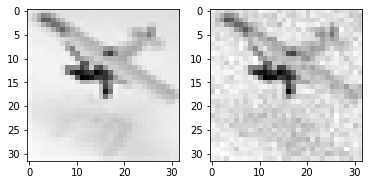

25  :  [0.34191385] 25
50  :  [0.34191385] 25
75  :  [0.3414958] 25
100  :  [0.3414958] 25
125  :  [0.35321158] 25
150  :  [0.35307765] 25
175  :  [0.35307765] 25
200  :  [0.35307765] 25
225  :  [0.35307765] 25
250  :  [0.35307765] 25
275  :  [0.35307765] 25
300  :  [0.35307765] 25
325  :  [0.35334864] 25
350  :  [0.35321736] 25
375  :  [0.35321736] 25
400  :  [0.35321736] 25
425  :  [0.3542484] 25
450  :  [0.3555593] 25
475  :  [0.35564822] 25
500  :  [0.35564822] 25
525  :  [0.35564822] 25
550  :  [0.35684508] 25
575  :  [0.3574173] 25
600  :  [0.35790122] 25
625  :  [0.35790122] 25
650  :  [0.35821128] 25
675  :  [0.35821128] 25
700  :  [0.35861978] 25
725  :  [0.35881025] 25
750  :  [0.35892206] 25
775  :  [0.35908875] 25
800  :  [0.3591714] 25
825  :  [0.35965174] 25
850  :  [0.35965174] 25
875  :  [0.35965174] 25
900  :  [0.35971802] 25
925  :  [0.35971802] 25
950  :  [0.35971802] 25
975  :  [0.35971802] 25
1000  :  [0.35971802] 25
1025  :  [0.3598786] 25
1050  :  [0.36007217] 25

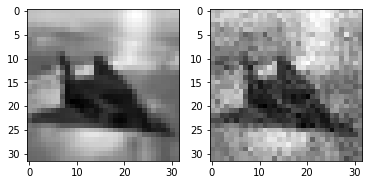

25  :  [0.39911437] 25
50  :  [0.39911437] 25
75  :  [0.39911437] 25
100  :  [0.39911437] 25
125  :  [0.399769] 25
150  :  [0.399769] 25
175  :  [0.399769] 25
200  :  [0.399769] 25
225  :  [0.4004575] 25
250  :  [0.4021117] 25
275  :  [0.4021117] 25
300  :  [0.4021117] 25
325  :  [0.40218493] 25
350  :  [0.40284446] 25
375  :  [0.40284446] 25
400  :  [0.40284446] 25
425  :  [0.40284446] 25
450  :  [0.40310037] 25
475  :  [0.40310037] 25
500  :  [0.40310037] 25
525  :  [0.40310037] 25
550  :  [0.40310037] 25
575  :  [0.40310037] 25
600  :  [0.4031255] 25
625  :  [0.40323246] 25
650  :  [0.4033012] 25
675  :  [0.40338266] 25
700  :  [0.40348822] 25
725  :  [0.40349954] 25
750  :  [0.4035433] 25
775  :  [0.40364414] 25
800  :  [0.40366226] 25
825  :  [0.40366226] 25
850  :  [0.40367866] 25
875  :  [0.40368107] 25
900  :  [0.40374047] 25
925  :  [0.40376252] 25
950  :  [0.40380967] 25
975  :  [0.40386805] 25
1000  :  [0.40395734] 25
NOT IMPROVING!  1025  :  [0.40395734] 25
Time:  269.73934

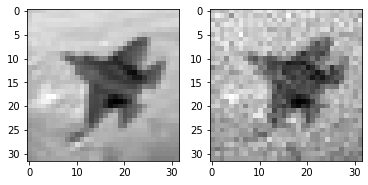

25  :  [0.3206989] 25
50  :  [0.32112938] 25
75  :  [0.3214858] 25
100  :  [0.3214858] 25
125  :  [0.3214858] 25
150  :  [0.3215993] 25
175  :  [0.3216033] 25
200  :  [0.3216033] 25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide


225  :  [0.32162997] 25
250  :  [0.3216033] 25
275  :  [0.3229727] 25
300  :  [0.3229727] 25
325  :  [0.3229727] 25
350  :  [0.32406485] 25
375  :  [0.3245502] 25
400  :  [0.32456854] 25
425  :  [0.32456854] 25
450  :  [0.32456854] 25
475  :  [0.32456854] 25
500  :  [0.32456854] 25
525  :  [0.32456854] 25
550  :  [0.32456854] 25
575  :  [0.3247297] 25
600  :  [0.32485205] 25
625  :  [0.32495838] 25
650  :  [0.32526132] 25
675  :  [0.32526132] 25
700  :  [0.32526132] 25
725  :  [0.32526132] 25
750  :  [0.32567784] 25
775  :  [0.32567784] 25
800  :  [0.32567784] 25
825  :  [0.32578215] 25
850  :  [0.32578215] 25
875  :  [0.32580703] 25
900  :  [0.32596216] 25
925  :  [0.32601523] 25
950  :  [0.3262274] 25
975  :  [0.32627636] 25
1000  :  [0.32659927] 25
1025  :  [0.32663596] 25
1050  :  [0.32678926] 25
1075  :  [0.32678926] 25
1100  :  [0.32678926] 25
NOT IMPROVING!  1125  :  [0.32678926] 25
Time:  306.22082138061523  seconds
Predicted class:  [2]


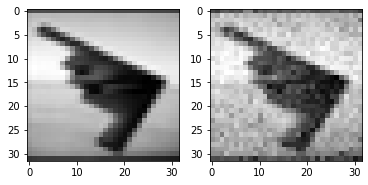

25  :  [0.36255887] 25
50  :  [0.3653059] 25
75  :  [0.36579573] 25
100  :  [0.3656352] 25
125  :  [0.3656352] 25
150  :  [0.36609966] 25
175  :  [0.36609763] 25
200  :  [0.36609763] 25
225  :  [0.36609763] 25
250  :  [0.36609763] 25
275  :  [0.36706805] 25
300  :  [0.36711198] 25
325  :  [0.36772996] 25
350  :  [0.36803293] 25
375  :  [0.36806023] 25
400  :  [0.36844993] 25
425  :  [0.36882427] 25
FOUND!  450  :  [0.36892924] 25
Time:  124.28276824951172  seconds
Predicted class:  [2]


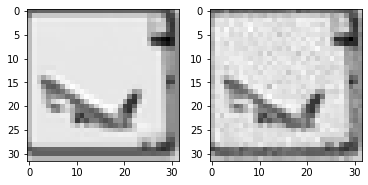

25  :  [0.42244127] 25
50  :  [0.43040234] 25
75  :  [0.43437093] 25
100  :  [0.43437093] 25
125  :  [0.43437093] 25
150  :  [0.43594623] 25
175  :  [0.43594623] 25
FOUND!  200  :  [0.43727782] 25
Time:  55.470967292785645  seconds
Predicted class:  [2]


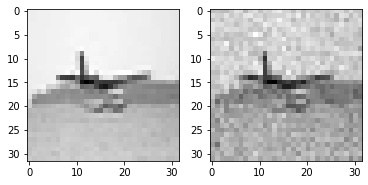

25  :  [-0.00703868] 25
50  :  [0.04244466] 25
75  :  [0.00225373] 25
100  :  [0.06276745] 25
125  :  [0.10318065] 25
150  :  [0.25087416] 25
175  :  [0.24971177] 25
200  :  [0.24971177] 25
225  :  [0.24971177] 25
250  :  [0.24971177] 25
275  :  [0.24971177] 25
300  :  [0.24971177] 25
325  :  [0.24971177] 25
350  :  [0.24971177] 25
375  :  [0.24971177] 25
400  :  [0.24971177] 25
425  :  [0.24971177] 25
450  :  [0.25387478] 25
475  :  [0.25714976] 25
500  :  [0.25714976] 25
525  :  [0.25714976] 25
550  :  [0.26117182] 25
575  :  [0.26117182] 25
600  :  [0.26117182] 25
625  :  [0.26117182] 25
650  :  [0.26117182] 25
675  :  [0.26117182] 25
700  :  [0.26117182] 25
725  :  [0.26117182] 25
750  :  [0.26117182] 25
775  :  [0.2613491] 25
800  :  [0.26160407] 25
825  :  [0.26188785] 25
850  :  [0.26242498] 25
875  :  [0.26246557] 25
900  :  [0.26302052] 25
925  :  [0.26301768] 25
950  :  [0.26306224] 25
975  :  [0.26319817] 25
1000  :  [0.26337212] 25
1025  :  [0.26368487] 25
1050  :  [0.26405

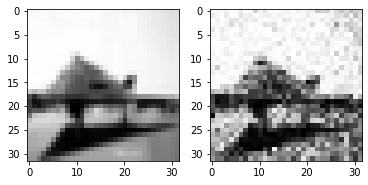

25  :  [0.2029326] 25
50  :  [0.2655658] 25
75  :  [0.2634766] 25
100  :  [0.2634766] 25
125  :  [0.2634766] 25
150  :  [0.2634766] 25
175  :  [0.2634766] 25
200  :  [0.2770707] 25
225  :  [0.27178624] 25
250  :  [0.27178624] 25
275  :  [0.28683603] 25
300  :  [0.28564888] 25
325  :  [0.28615415] 25
350  :  [0.295856] 25
375  :  [0.29620415] 25
400  :  [0.29620415] 25
425  :  [0.29620415] 25
450  :  [0.29620415] 25
475  :  [0.29620415] 25
500  :  [0.29620415] 25
525  :  [0.29620415] 25
550  :  [0.29620415] 25
575  :  [0.29620415] 25
600  :  [0.29620415] 25
625  :  [0.2998975] 25
650  :  [0.2998975] 25
675  :  [0.3026843] 25
700  :  [0.30268604] 25
725  :  [0.30268604] 25
750  :  [0.303785] 25
775  :  [0.30378538] 25
800  :  [0.30378538] 25
825  :  [0.3041106] 25
850  :  [0.30420104] 25
875  :  [0.3043832] 25
900  :  [0.30486315] 25
925  :  [0.30486315] 25
950  :  [0.30486315] 25
975  :  [0.30492875] 25
1000  :  [0.30492875] 25
1025  :  [0.30492875] 25
1050  :  [0.30492875] 25
1075  :  

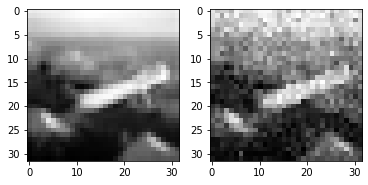

25  :  [0.2516011] 25
50  :  [0.2516011] 25
75  :  [0.25650692] 25
100  :  [0.30275354] 25
125  :  [0.30938828] 25
150  :  [0.3096032] 25
175  :  [0.31404912] 25
200  :  [0.31404912] 25
225  :  [0.31404912] 25
250  :  [0.31404912] 25
275  :  [0.31404912] 25
300  :  [0.31782433] 25
325  :  [0.32122868] 25
350  :  [0.32340622] 25
375  :  [0.32342935] 25
400  :  [0.32342935] 25
425  :  [0.32342935] 25
450  :  [0.32342935] 25
475  :  [0.3237902] 25
500  :  [0.32374585] 25
525  :  [0.3243336] 25
550  :  [0.32448262] 25
575  :  [0.3258162] 25
600  :  [0.32607073] 25
625  :  [0.32785118] 25
650  :  [0.32785118] 25
675  :  [0.32791826] 25
700  :  [0.32802898] 25
725  :  [0.3281583] 25
750  :  [0.32857147] 25
775  :  [0.32857147] 25
800  :  [0.32857147] 25
825  :  [0.32886988] 25
850  :  [0.3295321] 25
875  :  [0.3295321] 25
900  :  [0.32969838] 25
925  :  [0.3299146] 25
950  :  [0.33015203] 25
975  :  [0.3301522] 25
1000  :  [0.3302464] 25
1025  :  [0.33043897] 25
1050  :  [0.3304993] 25
1075 

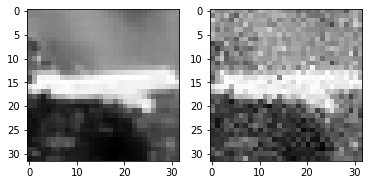

25  :  [0.43462133] 25
50  :  [0.43462133] 25
75  :  [0.43462133] 25
100  :  [0.43512243] 25
125  :  [0.43512243] 25
150  :  [0.43512243] 25
175  :  [0.43628684] 25
200  :  [0.43628684] 25
225  :  [0.43628684] 25
FOUND!  250  :  [0.43655616] 25
Time:  66.16236591339111  seconds
Predicted class:  [2]


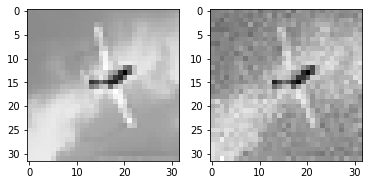

25  :  [0.30637753] 25
50  :  [0.35297635] 25
75  :  [0.35396242] 25
100  :  [0.35396242] 25
125  :  [0.35684586] 25
150  :  [0.35688657] 25
175  :  [0.35707298] 25
200  :  [0.35707277] 25
225  :  [0.35707277] 25
250  :  [0.35788065] 25
275  :  [0.35757947] 25
300  :  [0.35757947] 25
325  :  [0.35757947] 25
350  :  [0.35757947] 25
375  :  [0.35757947] 25
400  :  [0.35757947] 25
425  :  [0.35757947] 25
450  :  [0.35757947] 25
475  :  [0.35757947] 25
500  :  [0.35949126] 25
525  :  [0.35949126] 25
550  :  [0.35949126] 25
575  :  [0.35949126] 25
600  :  [0.36039132] 25
625  :  [0.36039132] 25
650  :  [0.36039132] 25
675  :  [0.36039132] 25
700  :  [0.36072046] 25
725  :  [0.36077976] 25
750  :  [0.36077976] 25
775  :  [0.36077976] 25
800  :  [0.36077976] 25
825  :  [0.36105895] 25
850  :  [0.361069] 25
875  :  [0.36137265] 25
900  :  [0.36201137] 25
925  :  [0.3620175] 25
950  :  [0.3620175] 25
975  :  [0.3620175] 25
1000  :  [0.3620175] 25
1025  :  [0.3620175] 25
1050  :  [0.3624807] 25


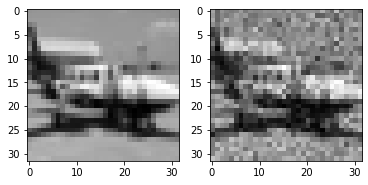

25  :  [0.38377607] 25
50  :  [0.38377607] 25
75  :  [0.38377607] 25
100  :  [0.38377607] 25
125  :  [0.39548635] 25
150  :  [0.39548635] 25
175  :  [0.39548635] 25
200  :  [0.39548635] 25
225  :  [0.39548635] 25
FOUND!  250  :  [0.39734063] 25
Time:  64.0881724357605  seconds
Predicted class:  [2]


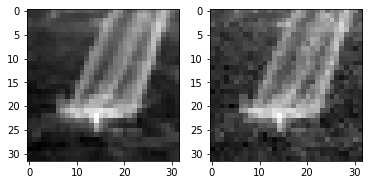

25  :  [0.3546592] 25
50  :  [0.3546592] 25
75  :  [0.35439706] 25
100  :  [0.3547228] 25
125  :  [0.35562432] 25
150  :  [0.35716063] 25
175  :  [0.35717952] 25
200  :  [0.35752755] 25
225  :  [0.35752755] 25
250  :  [0.3575579] 25
275  :  [0.35752332] 25
300  :  [0.35752332] 25
325  :  [0.35756347] 25
350  :  [0.35756347] 25
375  :  [0.35756347] 25
400  :  [0.35756347] 25
425  :  [0.3585842] 25
450  :  [0.3586435] 25
475  :  [0.3588401] 25
500  :  [0.35929787] 25
525  :  [0.3603277] 25
550  :  [0.3603277] 25
575  :  [0.3605246] 25
600  :  [0.3605246] 25
625  :  [0.3605246] 25
650  :  [0.3605246] 25
675  :  [0.360544] 25
700  :  [0.360544] 25
725  :  [0.36061692] 25
750  :  [0.3607] 25
775  :  [0.3607272] 25
800  :  [0.3608318] 25
825  :  [0.3608371] 25
850  :  [0.3608889] 25
875  :  [0.3609321] 25
900  :  [0.36095974] 25
925  :  [0.36099368] 25
950  :  [0.3610592] 25
975  :  [0.36111122] 25
1000  :  [0.36114615] 25
1025  :  [0.36120164] 25
1050  :  [0.36129156] 25
1075  :  [0.3613423

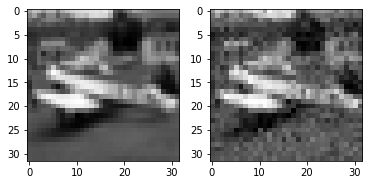

25  :  [0.22659174] 25
50  :  [0.22659174] 25
75  :  [0.23162553] 25
100  :  [0.23260465] 25
125  :  [0.23414707] 25
150  :  [0.23414707] 25
175  :  [0.23414707] 25
200  :  [0.23490149] 25
225  :  [0.23490149] 25
250  :  [0.23536807] 25
275  :  [0.23693773] 25
300  :  [0.2371119] 25
325  :  [0.23715258] 25
350  :  [0.23715258] 25
375  :  [0.2373353] 25
400  :  [0.23831627] 25
425  :  [0.23865503] 25
450  :  [0.23956186] 25
475  :  [0.24005154] 25
500  :  [0.24051756] 25
525  :  [0.24079216] 25
550  :  [0.24089581] 25
575  :  [0.24108711] 25
600  :  [0.2411941] 25
625  :  [0.24148172] 25
650  :  [0.24194881] 25
675  :  [0.24194881] 25
700  :  [0.24194881] 25
725  :  [0.24194881] 25
750  :  [0.24194881] 25
775  :  [0.24197733] 25
800  :  [0.24210072] 25
825  :  [0.24216601] 25
850  :  [0.24216601] 25
875  :  [0.24221125] 25
900  :  [0.24223566] 25
925  :  [0.24246985] 25
950  :  [0.24250543] 25
975  :  [0.24255428] 25
1000  :  [0.24255696] 25
1025  :  [0.24255767] 25
NOT IMPROVING!  1050

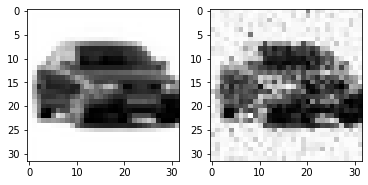

25  :  [0.30783784] 25
50  :  [0.30783784] 25
75  :  [0.30783784] 25
100  :  [0.3131587] 25
125  :  [0.3131587] 25
150  :  [0.3139814] 25
175  :  [0.3139814] 25
200  :  [0.3139814] 25
225  :  [0.3139814] 25
250  :  [0.3139814] 25
275  :  [0.3139814] 25
300  :  [0.3139814] 25
325  :  [0.31513166] 25
350  :  [0.31582803] 25
375  :  [0.31582803] 25
400  :  [0.31799653] 25
425  :  [0.31799653] 25
450  :  [0.31799653] 25
475  :  [0.31799653] 25
500  :  [0.31799653] 25
525  :  [0.31799653] 25
550  :  [0.31799653] 25
575  :  [0.31799653] 25
600  :  [0.31799653] 25
625  :  [0.31799653] 25
650  :  [0.31799653] 25
675  :  [0.31799653] 25
700  :  [0.31799653] 25
725  :  [0.31799653] 25
750  :  [0.31799653] 25
775  :  [0.31799653] 25
800  :  [0.31799653] 25
825  :  [0.31881142] 25
850  :  [0.31881562] 25
875  :  [0.31881562] 25
900  :  [0.3197095] 25
925  :  [0.3197095] 25
950  :  [0.3197095] 25
975  :  [0.3197095] 25
1000  :  [0.3197095] 25
1025  :  [0.3197095] 25
1050  :  [0.3197095] 25
1075  : 

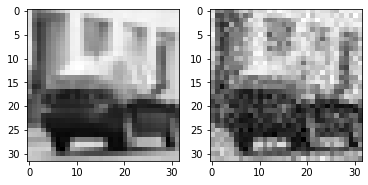

25  :  [0.29006147] 25
50  :  [0.2921148] 25
75  :  [0.3158781] 25
100  :  [0.3158781] 25
125  :  [0.3212479] 25
150  :  [0.3221902] 25
175  :  [0.3221902] 25
200  :  [0.3221923] 25
225  :  [0.322969] 25
250  :  [0.322969] 25
275  :  [0.322969] 25
300  :  [0.32330477] 25
325  :  [0.32330477] 25
350  :  [0.32430154] 25
375  :  [0.3248322] 25
400  :  [0.32522798] 25
425  :  [0.32528555] 25
450  :  [0.32561263] 25
475  :  [0.32599038] 25
500  :  [0.32611784] 25
525  :  [0.32709044] 25
550  :  [0.32716364] 25
575  :  [0.3271767] 25
600  :  [0.32719204] 25
625  :  [0.32721898] 25
650  :  [0.32733575] 25
675  :  [0.32733575] 25
700  :  [0.32736138] 25
725  :  [0.32756376] 25
750  :  [0.32756376] 25
775  :  [0.32756823] 25
800  :  [0.32766116] 25
825  :  [0.32766116] 25
850  :  [0.32783264] 25
875  :  [0.32785803] 25
NOT IMPROVING!  900  :  [0.3278759] 25
Time:  235.71367478370667  seconds
Predicted class:  [6]


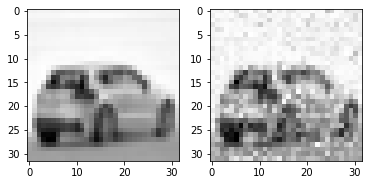

25  :  [0.34113544] 25
50  :  [0.3677515] 25
75  :  [0.3690889] 25
100  :  [0.3738876] 25
125  :  [0.3728068] 25
150  :  [0.3728068] 25
175  :  [0.3728068] 25
200  :  [0.3769524] 25
225  :  [0.37719244] 25
250  :  [0.37719244] 25
275  :  [0.37719244] 25
300  :  [0.37719244] 25
325  :  [0.37719244] 25
350  :  [0.37719244] 25
375  :  [0.37719244] 25
400  :  [0.37719244] 25
425  :  [0.37719244] 25
450  :  [0.37719244] 25
475  :  [0.37719244] 25
500  :  [0.37719244] 25
525  :  [0.37719244] 25
550  :  [0.37719244] 25
575  :  [0.37719244] 25
600  :  [0.37731352] 25
625  :  [0.37731352] 25
650  :  [0.37998524] 25
675  :  [0.3799218] 25
700  :  [0.3799218] 25
725  :  [0.38007084] 25
750  :  [0.3800186] 25
775  :  [0.3800186] 25
800  :  [0.3800186] 25
825  :  [0.3800186] 25
850  :  [0.3800186] 25
875  :  [0.3809814] 25
900  :  [0.38279742] 25
925  :  [0.38279644] 25
950  :  [0.3839758] 25
975  :  [0.3854146] 25
1000  :  [0.38541776] 25
1025  :  [0.38541776] 25
1050  :  [0.38541776] 25
1075  :  

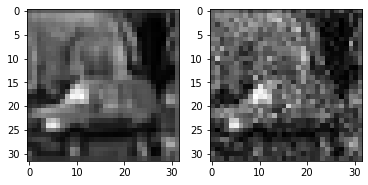

25  :  [0.37028104] 25
50  :  [0.37028104] 25
75  :  [0.37687337] 25
100  :  [0.3792305] 25
125  :  [0.37955844] 25
150  :  [0.38120633] 25
175  :  [0.38192296] 25
200  :  [0.38192296] 25
225  :  [0.38192296] 25
250  :  [0.38192296] 25
275  :  [0.38399082] 25
300  :  [0.3841746] 25
325  :  [0.3841746] 25
350  :  [0.38475275] 25
375  :  [0.38573256] 25
400  :  [0.38597906] 25
425  :  [0.38597944] 25
450  :  [0.38597944] 25
475  :  [0.38597944] 25
500  :  [0.38597944] 25
525  :  [0.3867972] 25
550  :  [0.38715434] 25
575  :  [0.38716406] 25
600  :  [0.38716406] 25
625  :  [0.38750377] 25
650  :  [0.3876343] 25
675  :  [0.3876483] 25
700  :  [0.3877714] 25
725  :  [0.3877714] 25
750  :  [0.3877714] 25
775  :  [0.38782936] 25
800  :  [0.38782948] 25
825  :  [0.38790447] 25
850  :  [0.38793838] 25
875  :  [0.38806978] 25
900  :  [0.38806978] 25
925  :  [0.38806978] 25
950  :  [0.38808927] 25
975  :  [0.38808927] 25
1000  :  [0.38810176] 25
1025  :  [0.38814393] 25
NOT IMPROVING!  1050  :  [

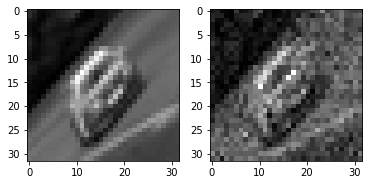

25  :  [0.32584208] 25
50  :  [0.32584208] 25
75  :  [0.34421062] 25
100  :  [0.34358114] 25
125  :  [0.34358114] 25
150  :  [0.34358114] 25
175  :  [0.344967] 25
200  :  [0.34481218] 25
225  :  [0.34499002] 25
250  :  [0.34499002] 25
275  :  [0.34499002] 25
300  :  [0.34918565] 25
325  :  [0.3525138] 25
350  :  [0.35643935] 25
375  :  [0.35858977] 25
400  :  [0.35985044] 25
425  :  [0.36075866] 25
450  :  [0.36234397] 25
475  :  [0.3623852] 25
500  :  [0.36464667] 25
525  :  [0.36464667] 25
550  :  [0.36504552] 25
575  :  [0.3650611] 25
600  :  [0.36601543] 25
625  :  [0.36609787] 25
650  :  [0.36609843] 25
675  :  [0.3661142] 25
700  :  [0.36613503] 25
725  :  [0.36613503] 25
750  :  [0.36670494] 25
775  :  [0.36670494] 25
800  :  [0.36670494] 25
825  :  [0.36681223] 25
850  :  [0.36681223] 25
875  :  [0.36685663] 25
900  :  [0.36685663] 25
925  :  [0.36686987] 25
950  :  [0.36691588] 25
975  :  [0.3669446] 25
1000  :  [0.3669446] 25
1025  :  [0.3669446] 25
1050  :  [0.3670032] 25
10

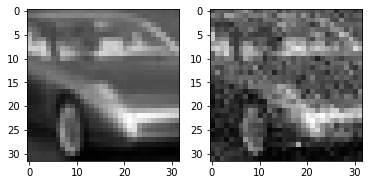

25  :  [0.09430994] 25
50  :  [0.20985784] 25
75  :  [0.20074987] 25
100  :  [0.21774061] 25
125  :  [0.22755651] 25
150  :  [0.25053826] 25
175  :  [0.2571665] 25
200  :  [0.260446] 25
225  :  [0.27285194] 25
250  :  [0.27285194] 25
275  :  [0.2744316] 25
300  :  [0.27818066] 25
325  :  [0.27893758] 25
350  :  [0.27893758] 25
375  :  [0.27893758] 25
400  :  [0.28355193] 25
425  :  [0.28355193] 25
450  :  [0.28355193] 25
475  :  [0.2863404] 25
500  :  [0.28569794] 25
525  :  [0.2978789] 25
550  :  [0.29746538] 25
575  :  [0.30452186] 25
600  :  [0.30695218] 25
625  :  [0.30703497] 25
650  :  [0.30727237] 25
675  :  [0.30727237] 25
700  :  [0.3115914] 25
725  :  [0.31337258] 25
750  :  [0.31337258] 25
775  :  [0.31337258] 25
800  :  [0.31337258] 25
825  :  [0.31337258] 25
850  :  [0.31337258] 25
875  :  [0.31347084] 25
900  :  [0.31454217] 25
925  :  [0.3153658] 25
950  :  [0.31574768] 25
975  :  [0.31574768] 25
1000  :  [0.31574768] 25
1025  :  [0.31574768] 25
1050  :  [0.31574768] 25


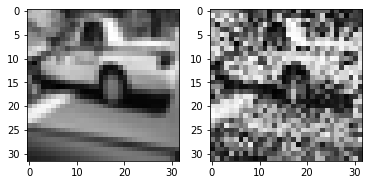

25  :  [0.34513366] 25
50  :  [0.37320623] 25
75  :  [0.37872466] 25
100  :  [0.37872583] 25
125  :  [0.38685295] 25
150  :  [0.38685295] 25
175  :  [0.38685295] 25
200  :  [0.38685295] 25
225  :  [0.38685295] 25
250  :  [0.38685295] 25
275  :  [0.38685295] 25
300  :  [0.38685295] 25
325  :  [0.38685295] 25
350  :  [0.38685295] 25
375  :  [0.38685295] 25
400  :  [0.38685295] 25
425  :  [0.38685295] 25
450  :  [0.38685295] 25
475  :  [0.38685295] 25
500  :  [0.38685295] 25
525  :  [0.38685295] 25
550  :  [0.38685295] 25
575  :  [0.38685295] 25
600  :  [0.38685295] 25
625  :  [0.38685295] 25
650  :  [0.38685295] 25
675  :  [0.38685295] 25
700  :  [0.38685295] 25
725  :  [0.3868749] 25
750  :  [0.3868749] 25
775  :  [0.3868749] 25
800  :  [0.3868749] 25
825  :  [0.3868749] 25
850  :  [0.3868749] 25
875  :  [0.3868749] 25
NOT IMPROVING!  900  :  [0.3868749] 25
Time:  220.43332529067993  seconds
Predicted class:  [2]


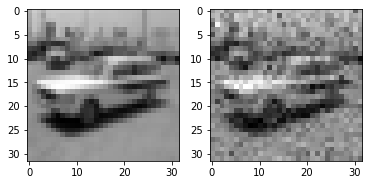

25  :  [0.25527832] 25
50  :  [0.25527832] 25
75  :  [0.29294845] 25
100  :  [0.29597175] 25
125  :  [0.29787728] 25
150  :  [0.30416775] 25
175  :  [0.30635065] 25
200  :  [0.30646724] 25
225  :  [0.3081026] 25
250  :  [0.3081026] 25
275  :  [0.3087539] 25
300  :  [0.30879378] 25
325  :  [0.3090658] 25
350  :  [0.3090658] 25
375  :  [0.3090658] 25
400  :  [0.3090658] 25
425  :  [0.3090658] 25
450  :  [0.3090658] 25
475  :  [0.30940664] 25
500  :  [0.30940664] 25
525  :  [0.30958664] 25
550  :  [0.30992654] 25
575  :  [0.30992654] 25
600  :  [0.31044734] 25
625  :  [0.31086713] 25
650  :  [0.31117254] 25
675  :  [0.31117254] 25
700  :  [0.31117254] 25
725  :  [0.31126115] 25
750  :  [0.31187588] 25
775  :  [0.31187588] 25
800  :  [0.31187588] 25
825  :  [0.31189406] 25
850  :  [0.31189406] 25
875  :  [0.31227303] 25
900  :  [0.31252384] 25
925  :  [0.31269717] 25
950  :  [0.31269717] 25
975  :  [0.31269717] 25
NOT IMPROVING!  1000  :  [0.31269717] 25
Time:  250.15092492103577  seconds


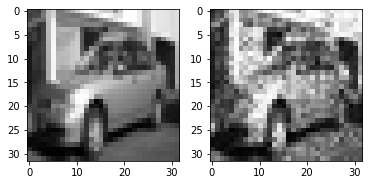

25  :  [0.3698087] 25
50  :  [0.3698087] 25
75  :  [0.37002477] 25
100  :  [0.37026665] 25
125  :  [0.37040246] 25
150  :  [0.37040246] 25
175  :  [0.37089878] 25
200  :  [0.37089878] 25
225  :  [0.37089878] 25
250  :  [0.37089878] 25
275  :  [0.37089878] 25
300  :  [0.3711957] 25
325  :  [0.3711957] 25
350  :  [0.3711957] 25
375  :  [0.37148738] 25
400  :  [0.37148738] 25
425  :  [0.3715249] 25
450  :  [0.3715249] 25
475  :  [0.37169304] 25
500  :  [0.37174127] 25
525  :  [0.37180567] 25
550  :  [0.37180832] 25
575  :  [0.3718173] 25
600  :  [0.3719702] 25
625  :  [0.37197036] 25
650  :  [0.3721144] 25
675  :  [0.37215286] 25
700  :  [0.3722523] 25
725  :  [0.3723942] 25
750  :  [0.3724815] 25
775  :  [0.37249982] 25
NOT IMPROVING!  800  :  [0.37257114] 25
Time:  200.25586819648743  seconds
Predicted class:  [6]


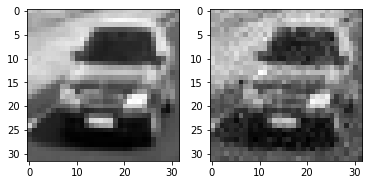

25  :  [0.340782] 25
50  :  [0.3452353] 25
75  :  [0.35302365] 25
100  :  [0.35284188] 25
125  :  [0.35284188] 25
150  :  [0.35284188] 25
175  :  [0.35284188] 25
200  :  [0.35284188] 25
225  :  [0.35284188] 25
250  :  [0.35284188] 25
275  :  [0.35284188] 25
300  :  [0.35284188] 25
325  :  [0.35284188] 25
350  :  [0.35284188] 25
375  :  [0.35284188] 25
400  :  [0.35284188] 25
425  :  [0.35284188] 25
450  :  [0.35284188] 25
475  :  [0.35284188] 25
500  :  [0.35284188] 25
525  :  [0.35284188] 25
550  :  [0.35428667] 25
575  :  [0.35428667] 25
600  :  [0.35501826] 25
625  :  [0.35501826] 25
650  :  [0.35501826] 25
675  :  [0.35501826] 25
700  :  [0.35501826] 25
725  :  [0.35501826] 25
750  :  [0.35501826] 25
775  :  [0.35501826] 25
800  :  [0.35501826] 25
825  :  [0.35501826] 25
850  :  [0.35501826] 25
875  :  [0.35501826] 25
900  :  [0.35501826] 25
925  :  [0.35501826] 25
950  :  [0.35501826] 25
975  :  [0.35501826] 25
1000  :  [0.35501826] 25
1025  :  [0.35501826] 25
1050  :  [0.35501826

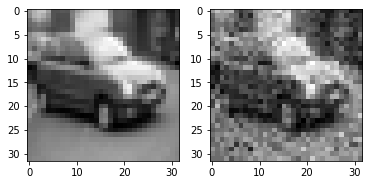

25  :  [0.2810555] 25
50  :  [0.30341446] 25
75  :  [0.31278414] 25
100  :  [0.31278414] 25
125  :  [0.31278414] 25
150  :  [0.31278414] 25
175  :  [0.31278414] 25
200  :  [0.31505126] 25
225  :  [0.3152858] 25
250  :  [0.3152858] 25
275  :  [0.3152858] 25
300  :  [0.3152858] 25
325  :  [0.3152858] 25
350  :  [0.3152858] 25
375  :  [0.3152858] 25
400  :  [0.3152858] 25
425  :  [0.3152858] 25
450  :  [0.3152858] 25
475  :  [0.3152858] 25
500  :  [0.3152858] 25
525  :  [0.31648976] 25
550  :  [0.3171927] 25
575  :  [0.3171927] 25
600  :  [0.3171927] 25
625  :  [0.3171927] 25
650  :  [0.3171927] 25
675  :  [0.3171927] 25
700  :  [0.3171927] 25
725  :  [0.31765237] 25
750  :  [0.31823432] 25
775  :  [0.31823432] 25
800  :  [0.3193364] 25
825  :  [0.31942242] 25
850  :  [0.31965554] 25
875  :  [0.3224182] 25
900  :  [0.3234064] 25
925  :  [0.3234064] 25
950  :  [0.3234064] 25
975  :  [0.3248299] 25
1000  :  [0.3248299] 25
1025  :  [0.3248299] 25
1050  :  [0.32509702] 25
1075  :  [0.32537162

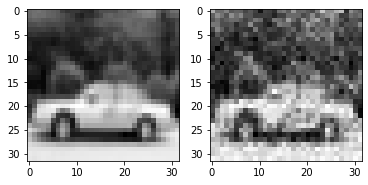

25  :  [0.21784015] 25
50  :  [0.21784015] 25
75  :  [0.20692596] 25
100  :  [0.26751053] 25
125  :  [0.2579146] 25
150  :  [0.2579146] 25
175  :  [0.2764879] 25
200  :  [0.2764879] 25
225  :  [0.2764879] 25
250  :  [0.2764879] 25
275  :  [0.28760213] 25
300  :  [0.2902072] 25
325  :  [0.28858286] 25
350  :  [0.28858286] 25
375  :  [0.28858286] 25
400  :  [0.2956998] 25
425  :  [0.29583788] 25
450  :  [0.29583788] 25
475  :  [0.29583788] 25
500  :  [0.29583788] 25
525  :  [0.29583788] 25
550  :  [0.29583788] 25
575  :  [0.29583788] 25
600  :  [0.29583788] 25
625  :  [0.29583788] 25
650  :  [0.29583788] 25
675  :  [0.29583788] 25
700  :  [0.29583788] 25
725  :  [0.29583788] 25
750  :  [0.29583788] 25
775  :  [0.29583788] 25
800  :  [0.29583788] 25
825  :  [0.29583788] 25
850  :  [0.29583788] 25
875  :  [0.29583788] 25
900  :  [0.29583788] 25
925  :  [0.29583788] 25
950  :  [0.29583788] 25
975  :  [0.29583788] 25
1000  :  [0.29583788] 25
1025  :  [0.29583788] 25
1050  :  [0.29583788] 25


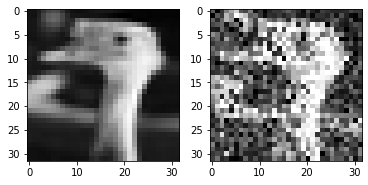

25  :  [0.39009938] 25
50  :  [0.39176357] 25
75  :  [0.39176357] 25
100  :  [0.3960473] 25
125  :  [0.39627093] 25
150  :  [0.3969037] 25
175  :  [0.39837304] 25
200  :  [0.3987667] 25
225  :  [0.3987667] 25
250  :  [0.3987667] 25
275  :  [0.3987667] 25
300  :  [0.39946228] 25
325  :  [0.3996027] 25
350  :  [0.4005137] 25
375  :  [0.4005137] 25
400  :  [0.40099826] 25
425  :  [0.40099826] 25
450  :  [0.40121096] 25
475  :  [0.4019631] 25
500  :  [0.40213326] 25
525  :  [0.40213326] 25
550  :  [0.40234753] 25
575  :  [0.4024782] 25
600  :  [0.40258998] 25
625  :  [0.402623] 25
650  :  [0.4027215] 25
675  :  [0.40277195] 25
700  :  [0.4027748] 25
725  :  [0.40279213] 25
750  :  [0.402804] 25
775  :  [0.40281108] 25
800  :  [0.4028278] 25
825  :  [0.40286076] 25
850  :  [0.40286076] 25
875  :  [0.40286583] 25
900  :  [0.40289062] 25
925  :  [0.402904] 25
NOT IMPROVING!  950  :  [0.40291762] 25
Time:  251.9753930568695  seconds
Predicted class:  [6]


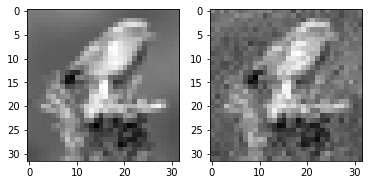

25  :  [0.4141817] 25
50  :  [0.4141817] 25
75  :  [0.41744748] 25
100  :  [0.41983688] 25
125  :  [0.42053404] 25
150  :  [0.42053404] 25
175  :  [0.42053404] 25
200  :  [0.42053404] 25
225  :  [0.42053404] 25
250  :  [0.42065644] 25
275  :  [0.42065644] 25
300  :  [0.42065644] 25
325  :  [0.42077097] 25
350  :  [0.42077097] 25
375  :  [0.42077097] 25
400  :  [0.42088932] 25
425  :  [0.42121616] 25
FOUND!  450  :  [0.42187244] 25
Time:  124.71925711631775  seconds
Predicted class:  [6]


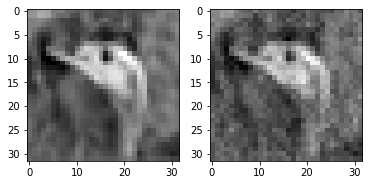

25  :  [0.2436069] 25
50  :  [0.2436069] 25
75  :  [0.21114618] 25
100  :  [0.21114618] 25
125  :  [0.21894139] 25
150  :  [0.23632836] 25
175  :  [0.26044238] 25
200  :  [0.2591364] 25
225  :  [0.30267307] 25
250  :  [0.33822864] 25
275  :  [0.33875078] 25
300  :  [0.33875078] 25
325  :  [0.33875078] 25
350  :  [0.33875078] 25
375  :  [0.33875078] 25
400  :  [0.33875078] 25
425  :  [0.33875078] 25
450  :  [0.33875078] 25
475  :  [0.33875078] 25
500  :  [0.33875078] 25
525  :  [0.33875078] 25
550  :  [0.33875078] 25
575  :  [0.33875078] 25
600  :  [0.33875078] 25
625  :  [0.33875078] 25
650  :  [0.33875078] 25
675  :  [0.33875078] 25
700  :  [0.33875078] 25
725  :  [0.33875078] 25
750  :  [0.33875078] 25
775  :  [0.33875078] 25
800  :  [0.33875078] 25
825  :  [0.341683] 25
850  :  [0.341683] 25
875  :  [0.341683] 25
900  :  [0.341683] 25
925  :  [0.341683] 25
950  :  [0.341683] 25
975  :  [0.341683] 25
1000  :  [0.3417027] 25
1025  :  [0.34343386] 25
1050  :  [0.34347135] 25
1075  :  [

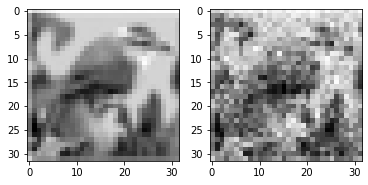

25  :  [0.13311955] 25
50  :  [0.21475953] 25
75  :  [0.23982923] 25
100  :  [0.23982923] 25
125  :  [0.23982923] 25
150  :  [0.23982923] 25
175  :  [0.23982923] 25
200  :  [0.23982923] 25
225  :  [0.23982923] 25
250  :  [0.2408837] 25
275  :  [0.26020786] 25
300  :  [0.26020786] 25
325  :  [0.26020786] 25
350  :  [0.26020786] 25
375  :  [0.2652365] 25
400  :  [0.28340793] 25
425  :  [0.28340793] 25
450  :  [0.28340793] 25
475  :  [0.28340793] 25
500  :  [0.2837363] 25
525  :  [0.28492337] 25
550  :  [0.2871043] 25
575  :  [0.2875961] 25
600  :  [0.28810072] 25
625  :  [0.28810072] 25
650  :  [0.28810072] 25
675  :  [0.28919986] 25
700  :  [0.2895185] 25
725  :  [0.2895185] 25
750  :  [0.29021776] 25
775  :  [0.29021776] 25
800  :  [0.29090673] 25
825  :  [0.29100016] 25
850  :  [0.29100016] 25
875  :  [0.29107654] 25
900  :  [0.29121906] 25
925  :  [0.29121906] 25
950  :  [0.29127926] 25
975  :  [0.29131955] 25
1000  :  [0.29131955] 25
1025  :  [0.29137444] 25
1050  :  [0.29139438] 25

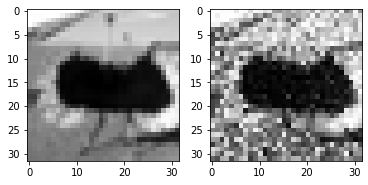

25  :  [0.24380045] 25
50  :  [0.24380045] 25
75  :  [0.28500476] 25
100  :  [0.28500476] 25
125  :  [0.28500476] 25
150  :  [0.28500476] 25
175  :  [0.28500476] 25
200  :  [0.32675678] 25
225  :  [0.32675678] 25
250  :  [0.32675678] 25
275  :  [0.32675678] 25
300  :  [0.32675678] 25
325  :  [0.32675678] 25
350  :  [0.32675678] 25
375  :  [0.3269587] 25
400  :  [0.3269587] 25
425  :  [0.3313355] 25
450  :  [0.3327443] 25
475  :  [0.33820784] 25
500  :  [0.33820784] 25
525  :  [0.33820784] 25
550  :  [0.33820784] 25
575  :  [0.34192824] 25
600  :  [0.35011882] 25
625  :  [0.3500622] 25
650  :  [0.3500622] 25
675  :  [0.3500622] 25
700  :  [0.35731938] 25
725  :  [0.35731938] 25
750  :  [0.3617506] 25
775  :  [0.3617506] 25
800  :  [0.3617506] 25
825  :  [0.36669168] 25
850  :  [0.36827984] 25
875  :  [0.36840025] 25
900  :  [0.36840025] 25
925  :  [0.36968702] 25
950  :  [0.36968702] 25
975  :  [0.37031522] 25
1000  :  [0.3713976] 25
1025  :  [0.37144172] 25
1050  :  [0.37180567] 25
107

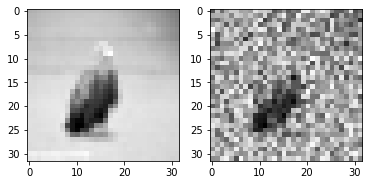

25  :  [0.15825865] 25
50  :  [0.23511036] 25
75  :  [0.27364746] 25
100  :  [0.27364746] 25
125  :  [0.27364746] 25
150  :  [0.27364746] 25
175  :  [0.27364746] 25
200  :  [0.27364746] 25
225  :  [0.27364746] 25
250  :  [0.27364746] 25
275  :  [0.2782029] 25
300  :  [0.2780979] 25
325  :  [0.2780979] 25
350  :  [0.2780979] 25
375  :  [0.28001654] 25
400  :  [0.30462703] 25
425  :  [0.32600152] 25
450  :  [0.3394646] 25
475  :  [0.33919314] 25
500  :  [0.33919314] 25
525  :  [0.3457039] 25
550  :  [0.34710622] 25
575  :  [0.34710622] 25
600  :  [0.34710622] 25
625  :  [0.34710622] 25
650  :  [0.34710622] 25
675  :  [0.34710622] 25
700  :  [0.34710622] 25
725  :  [0.34710622] 25
750  :  [0.34728247] 25
775  :  [0.34728247] 25
800  :  [0.34741345] 25
825  :  [0.34741345] 25
850  :  [0.3475288] 25
875  :  [0.3475288] 25
900  :  [0.34757817] 25
925  :  [0.34774834] 25
950  :  [0.34779587] 25
975  :  [0.34782845] 25
1000  :  [0.34789687] 25
1025  :  [0.3479823] 25
1050  :  [0.34806013] 25
1

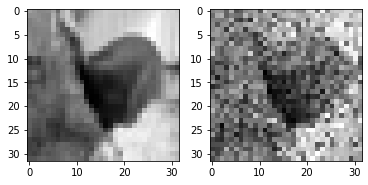

25  :  [0.28021497] 25
50  :  [0.28021497] 25
75  :  [0.28390265] 25
100  :  [0.28390265] 25
125  :  [0.29827374] 25
150  :  [0.29900092] 25
175  :  [0.30420798] 25
200  :  [0.3026621] 25
225  :  [0.30596113] 25
250  :  [0.30872142] 25
275  :  [0.31024975] 25
300  :  [0.31453007] 25
325  :  [0.3198077] 25
350  :  [0.32397014] 25
375  :  [0.32772028] 25
400  :  [0.32777554] 25
425  :  [0.32777554] 25
450  :  [0.3285945] 25
475  :  [0.32854953] 25
500  :  [0.32854953] 25
525  :  [0.32854953] 25
550  :  [0.33243954] 25
575  :  [0.33243954] 25
600  :  [0.33243954] 25
625  :  [0.33269155] 25
650  :  [0.33348596] 25
675  :  [0.3335445] 25
700  :  [0.3335445] 25
725  :  [0.3335445] 25
750  :  [0.3335445] 25
775  :  [0.3335445] 25
800  :  [0.33544812] 25
825  :  [0.3356378] 25
850  :  [0.3356446] 25
875  :  [0.3356446] 25
900  :  [0.33602893] 25
925  :  [0.33602893] 25
950  :  [0.33634615] 25
975  :  [0.33634615] 25
1000  :  [0.3364657] 25
1025  :  [0.3365848] 25
1050  :  [0.33658838] 25
1075 

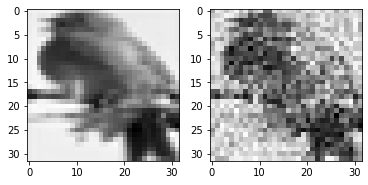

25  :  [0.15584481] 25
50  :  [0.15584481] 25
75  :  [0.31877092] 25
100  :  [0.31927112] 25
125  :  [0.31927112] 25
150  :  [0.32408392] 25
175  :  [0.3297581] 25
200  :  [0.3297581] 25
225  :  [0.3297581] 25
250  :  [0.336258] 25
275  :  [0.3401169] 25
300  :  [0.3401169] 25
325  :  [0.3401169] 25
350  :  [0.3401169] 25
375  :  [0.3401169] 25
400  :  [0.3401169] 25
425  :  [0.34407467] 25
450  :  [0.35389596] 25
475  :  [0.3539722] 25
500  :  [0.3539722] 25
525  :  [0.3539722] 25
550  :  [0.3669595] 25
575  :  [0.3669595] 25
600  :  [0.3669595] 25
625  :  [0.37353334] 25
650  :  [0.37353334] 25
675  :  [0.37567168] 25
700  :  [0.37567168] 25
725  :  [0.37612483] 25
750  :  [0.37887436] 25
775  :  [0.37887436] 25
800  :  [0.37887436] 25
825  :  [0.37887436] 25
850  :  [0.37887436] 25
875  :  [0.37887436] 25
900  :  [0.37887436] 25
925  :  [0.37991685] 25
950  :  [0.37991685] 25
975  :  [0.37991685] 25
1000  :  [0.38058358] 25
1025  :  [0.38072217] 25
1050  :  [0.38072217] 25
1075  :  

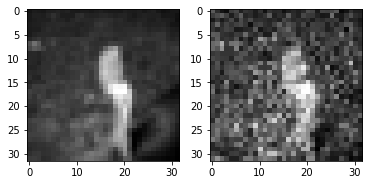

25  :  [0.3300706] 25
50  :  [0.33164573] 25
75  :  [0.33832884] 25
100  :  [0.33907968] 25
125  :  [0.33907968] 25
150  :  [0.33907968] 25
175  :  [0.33907968] 25
200  :  [0.3407768] 25
225  :  [0.34096456] 25
250  :  [0.34100604] 25
275  :  [0.34179974] 25
300  :  [0.34469014] 25
325  :  [0.34478474] 25
350  :  [0.34478474] 25
375  :  [0.34478474] 25
400  :  [0.34478474] 25
425  :  [0.34479666] 25
450  :  [0.34479666] 25
475  :  [0.34490734] 25
500  :  [0.34506094] 25
525  :  [0.3453111] 25
550  :  [0.3458436] 25
575  :  [0.34586084] 25
600  :  [0.34586084] 25
625  :  [0.34602973] 25
650  :  [0.34630078] 25
675  :  [0.34630078] 25
700  :  [0.34649396] 25
725  :  [0.3465256] 25
750  :  [0.3467097] 25
775  :  [0.34673864] 25
800  :  [0.34688258] 25
825  :  [0.34704012] 25
850  :  [0.34704012] 25
875  :  [0.34709272] 25
900  :  [0.34709272] 25
925  :  [0.34709272] 25
950  :  [0.34742147] 25
975  :  [0.34742147] 25
1000  :  [0.34746355] 25
1025  :  [0.34746355] 25
1050  :  [0.34746355] 2

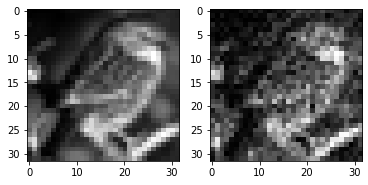

25  :  [0.18801059] 25
50  :  [0.25481835] 25
75  :  [0.28305188] 25
100  :  [0.33261293] 25
125  :  [0.33329147] 25
150  :  [0.33329147] 25
175  :  [0.33329147] 25
200  :  [0.33329147] 25
225  :  [0.33329147] 25
250  :  [0.33329147] 25
275  :  [0.33329147] 25
300  :  [0.33329147] 25
325  :  [0.33329147] 25
350  :  [0.33329147] 25
375  :  [0.33329147] 25
400  :  [0.33329147] 25
425  :  [0.3382494] 25
450  :  [0.33928722] 25
475  :  [0.33928722] 25
500  :  [0.33928722] 25
525  :  [0.34164864] 25
550  :  [0.34481567] 25
575  :  [0.34549975] 25
600  :  [0.34549975] 25
625  :  [0.34549975] 25
650  :  [0.3457421] 25
675  :  [0.34650496] 25
700  :  [0.34681314] 25
725  :  [0.34738272] 25
750  :  [0.3475585] 25
775  :  [0.34760502] 25
800  :  [0.34814414] 25
825  :  [0.34814414] 25
850  :  [0.34818] 25
875  :  [0.34818] 25
900  :  [0.3483594] 25
925  :  [0.34861404] 25
950  :  [0.34861404] 25
975  :  [0.3486549] 25
1000  :  [0.3486549] 25
1025  :  [0.3486549] 25
1050  :  [0.3486912] 25
1075  

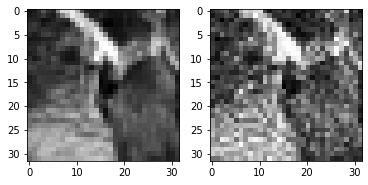

25  :  [0.03049305] 25
50  :  [0.09933837] 25
75  :  [0.13346325] 25
100  :  [0.26075602] 25
125  :  [0.3402769] 25
150  :  [0.33526784] 25
175  :  [0.35546535] 25
200  :  [0.36875814] 25
225  :  [0.3748432] 25
250  :  [0.3754722] 25
275  :  [0.38111067] 25
300  :  [0.38111067] 25
325  :  [0.38111067] 25
350  :  [0.38111067] 25
375  :  [0.38111067] 25
400  :  [0.38181686] 25
425  :  [0.38185632] 25
450  :  [0.3825125] 25
475  :  [0.3825125] 25
500  :  [0.38276643] 25
525  :  [0.38323689] 25
550  :  [0.38327825] 25
575  :  [0.3839466] 25
600  :  [0.38440603] 25
625  :  [0.3852762] 25
650  :  [0.3852762] 25
675  :  [0.3852762] 25
700  :  [0.3852762] 25
725  :  [0.3852777] 25
750  :  [0.3852777] 25
775  :  [0.38544402] 25
800  :  [0.385448] 25
825  :  [0.38572282] 25
850  :  [0.38572282] 25
875  :  [0.3858092] 25
900  :  [0.3859166] 25
925  :  [0.38595182] 25
950  :  [0.38596967] 25
975  :  [0.38604695] 25
1000  :  [0.38607302] 25
1025  :  [0.38608542] 25
NOT IMPROVING!  1050  :  [0.38614

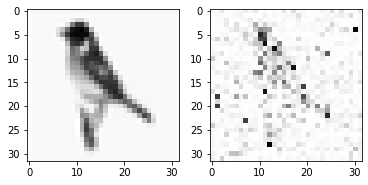

25  :  [0.25033364] 25
50  :  [0.285163] 25
75  :  [0.31757185] 25
100  :  [0.31757185] 25
125  :  [0.31757185] 25
150  :  [0.32425064] 25
175  :  [0.32425064] 25
200  :  [0.34868807] 25
225  :  [0.35306114] 25
250  :  [0.35306114] 25
275  :  [0.35306114] 25
300  :  [0.35306114] 25
325  :  [0.35306114] 25
350  :  [0.35306114] 25
375  :  [0.35306114] 25
400  :  [0.35306114] 25
425  :  [0.36020732] 25
450  :  [0.36020732] 25
475  :  [0.36020732] 25
500  :  [0.36020732] 25
525  :  [0.36020732] 25
550  :  [0.36020732] 25
575  :  [0.36020732] 25
600  :  [0.36020732] 25
625  :  [0.36020732] 25
650  :  [0.36593986] 25
675  :  [0.36597526] 25
700  :  [0.36597526] 25
725  :  [0.36755896] 25
750  :  [0.3699416] 25
775  :  [0.37144083] 25
800  :  [0.37144083] 25
825  :  [0.37225983] 25
850  :  [0.3722542] 25
875  :  [0.3722542] 25
900  :  [0.3722542] 25
925  :  [0.3722542] 25
950  :  [0.3723671] 25
975  :  [0.3723671] 25
1000  :  [0.3726382] 25
1025  :  [0.37264994] 25
1050  :  [0.37274522] 25
10

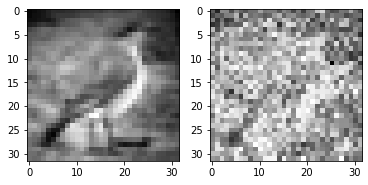

25  :  [-0.00819601] 25
50  :  [0.0868596] 25
75  :  [0.11467808] 25
100  :  [0.16885951] 25
125  :  [0.20278826] 25
150  :  [0.27279335] 25
175  :  [0.27279335] 25
200  :  [0.27279335] 25
225  :  [0.27559942] 25
250  :  [0.2767262] 25
275  :  [0.2767262] 25
300  :  [0.2767262] 25
325  :  [0.2767262] 25
350  :  [0.2770925] 25
375  :  [0.29123542] 25
400  :  [0.29731554] 25
425  :  [0.29731554] 25
450  :  [0.29731554] 25
475  :  [0.29731554] 25
500  :  [0.29731554] 25
525  :  [0.301408] 25
550  :  [0.31028062] 25
575  :  [0.3114229] 25
600  :  [0.31268245] 25
625  :  [0.32675108] 25
650  :  [0.34614247] 25
675  :  [0.34614247] 25
700  :  [0.34614247] 25
725  :  [0.34614247] 25
750  :  [0.34614247] 25
775  :  [0.35238257] 25
800  :  [0.35263395] 25
825  :  [0.35263395] 25
850  :  [0.35506585] 25
875  :  [0.35593218] 25
900  :  [0.35593218] 25
925  :  [0.35593218] 25
950  :  [0.35596037] 25
975  :  [0.35619265] 25
1000  :  [0.35736746] 25
1025  :  [0.35736746] 25
1050  :  [0.35787648] 25


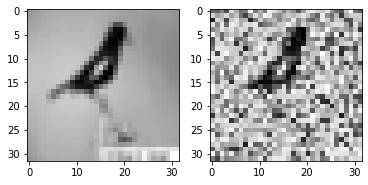

25  :  [0.37186444] 25
50  :  [0.37186444] 25
75  :  [0.37193653] 25
100  :  [0.37256676] 25
125  :  [0.3733632] 25
150  :  [0.3733632] 25
175  :  [0.3737108] 25
200  :  [0.3737108] 25
225  :  [0.37419233] 25
250  :  [0.37419233] 25
275  :  [0.37448397] 25
300  :  [0.37448397] 25
325  :  [0.37448397] 25
350  :  [0.37452054] 25
375  :  [0.37452054] 25
400  :  [0.3745743] 25
425  :  [0.3746007] 25
450  :  [0.37470448] 25
475  :  [0.37472934] 25
500  :  [0.37492928] 25
525  :  [0.37495196] 25
550  :  [0.37500563] 25
575  :  [0.37500563] 25
600  :  [0.37503123] 25
625  :  [0.37509266] 25
650  :  [0.37517646] 25
675  :  [0.37518036] 25
700  :  [0.37522703] 25
725  :  [0.37523186] 25
750  :  [0.37523186] 25
775  :  [0.37532592] 25
NOT IMPROVING!  800  :  [0.37532592] 25
Time:  215.1884970664978  seconds
Predicted class:  [2]


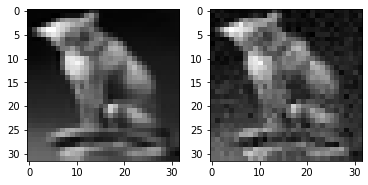

25  :  [0.3305734] 25
50  :  [0.36121505] 25
75  :  [0.36814058] 25
100  :  [0.36814058] 25
125  :  [0.36814058] 25
150  :  [0.36858404] 25
175  :  [0.36858404] 25
200  :  [0.36858404] 25
225  :  [0.37283227] 25
250  :  [0.3736863] 25
275  :  [0.3736863] 25
300  :  [0.3736863] 25
325  :  [0.3736863] 25
350  :  [0.3736863] 25
375  :  [0.3745279] 25
400  :  [0.3777163] 25
425  :  [0.3777163] 25
450  :  [0.3777163] 25
475  :  [0.38049468] 25
500  :  [0.38038743] 25
525  :  [0.38038743] 25
550  :  [0.38038743] 25
575  :  [0.38423175] 25
600  :  [0.38426244] 25
625  :  [0.38426244] 25
650  :  [0.38426244] 25
675  :  [0.38426244] 25
700  :  [0.38426244] 25
725  :  [0.38426244] 25
750  :  [0.38560927] 25
775  :  [0.38578197] 25
800  :  [0.3860984] 25
825  :  [0.3860984] 25
850  :  [0.3860984] 25
875  :  [0.3860984] 25
900  :  [0.38622257] 25
925  :  [0.38622257] 25
950  :  [0.38622257] 25
975  :  [0.38630503] 25
1000  :  [0.38630503] 25
1025  :  [0.38636833] 25
1050  :  [0.38636833] 25
1075  

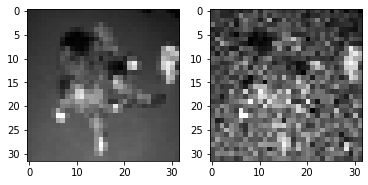

25  :  [0.14226547] 25
50  :  [0.1555306] 25
75  :  [0.29897994] 25
100  :  [0.29977423] 25
125  :  [0.29977423] 25
150  :  [0.29977423] 25
175  :  [0.29977423] 25
200  :  [0.29988217] 25
225  :  [0.29992712] 25
250  :  [0.29992712] 25
275  :  [0.30095696] 25
300  :  [0.30296767] 25
325  :  [0.303115] 25
350  :  [0.303115] 25
375  :  [0.3032628] 25
400  :  [0.30385306] 25
425  :  [0.3047979] 25
450  :  [0.305108] 25
475  :  [0.3060862] 25
500  :  [0.3060862] 25
525  :  [0.3060862] 25
550  :  [0.30619955] 25
575  :  [0.3064999] 25
600  :  [0.30721077] 25
625  :  [0.30720925] 25
650  :  [0.30773294] 25
675  :  [0.30793965] 25
700  :  [0.30793965] 25
725  :  [0.30793965] 25
750  :  [0.3079463] 25
775  :  [0.3079463] 25
800  :  [0.3081087] 25
825  :  [0.3082893] 25
850  :  [0.3083079] 25
875  :  [0.3084749] 25
900  :  [0.30848113] 25
925  :  [0.30849943] 25
950  :  [0.308769] 25
975  :  [0.30878413] 25
1000  :  [0.30884618] 25
1025  :  [0.30885243] 25
1050  :  [0.30888188] 25
NOT IMPROVING

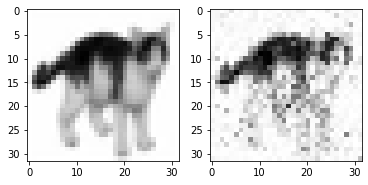

25  :  [0.22292331] 25
50  :  [0.2545553] 25
75  :  [0.32033938] 25
100  :  [0.3232171] 25
125  :  [0.3232171] 25
150  :  [0.3232171] 25
175  :  [0.3232171] 25
200  :  [0.3232171] 25
225  :  [0.3243269] 25
250  :  [0.32432678] 25
275  :  [0.32432678] 25
300  :  [0.32432678] 25
325  :  [0.32432678] 25
350  :  [0.32432678] 25
375  :  [0.32432678] 25
400  :  [0.3298405] 25
425  :  [0.3307268] 25
450  :  [0.3379081] 25
475  :  [0.33951968] 25
500  :  [0.34025913] 25
525  :  [0.34025913] 25
550  :  [0.34025913] 25
575  :  [0.34025913] 25
600  :  [0.3417148] 25
625  :  [0.3417148] 25
650  :  [0.3417148] 25
675  :  [0.3423754] 25
700  :  [0.3424255] 25
725  :  [0.34245008] 25
750  :  [0.34332478] 25
775  :  [0.34332478] 25
800  :  [0.3435128] 25
825  :  [0.3438909] 25
850  :  [0.3441161] 25
875  :  [0.34432468] 25
900  :  [0.34484386] 25
925  :  [0.34484386] 25
950  :  [0.34487873] 25
975  :  [0.34487873] 25
1000  :  [0.34491622] 25
1025  :  [0.34496677] 25
1050  :  [0.34496677] 25
1075  :  [

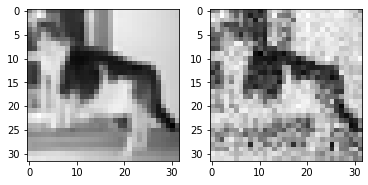

25  :  [0.33812618] 25
50  :  [0.33812618] 25
75  :  [0.3380592] 25
100  :  [0.34030217] 25
125  :  [0.34377456] 25
150  :  [0.34459907] 25
175  :  [0.344667] 25
200  :  [0.34610903] 25
225  :  [0.34645522] 25
250  :  [0.3467651] 25
275  :  [0.3467651] 25
300  :  [0.34681648] 25
325  :  [0.34736967] 25
350  :  [0.34737283] 25
375  :  [0.3479874] 25
400  :  [0.3479874] 25
425  :  [0.3479874] 25
450  :  [0.3479874] 25
475  :  [0.3483715] 25
500  :  [0.3483715] 25
525  :  [0.3483715] 25
550  :  [0.3483715] 25
575  :  [0.3483715] 25
600  :  [0.3483715] 25
625  :  [0.3483715] 25
650  :  [0.3484481] 25
675  :  [0.34864536] 25
700  :  [0.34869236] 25
725  :  [0.34876066] 25
750  :  [0.34889558] 25
775  :  [0.348914] 25
800  :  [0.348914] 25
825  :  [0.3489527] 25
850  :  [0.34904045] 25
875  :  [0.34904045] 25
900  :  [0.34904045] 25
925  :  [0.34905988] 25
950  :  [0.349117] 25
NOT IMPROVING!  975  :  [0.349117] 25
Time:  257.62468814849854  seconds
Predicted class:  [2]


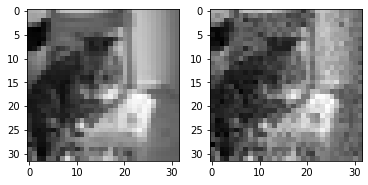

25  :  [0.38605207] 25
50  :  [0.38605207] 25
75  :  [0.38565934] 25
100  :  [0.38807243] 25
125  :  [0.38807243] 25
150  :  [0.38807243] 25
175  :  [0.389448] 25
200  :  [0.39981252] 25
225  :  [0.39981252] 25
250  :  [0.40220606] 25
275  :  [0.40220606] 25
300  :  [0.40220606] 25
325  :  [0.4051742] 25
350  :  [0.4051742] 25
375  :  [0.4051742] 25
400  :  [0.4051742] 25
425  :  [0.4051742] 25
450  :  [0.4051742] 25
475  :  [0.40663254] 25
500  :  [0.40689227] 25
525  :  [0.4068955] 25
550  :  [0.4068955] 25
575  :  [0.40734693] 25
600  :  [0.40734693] 25
625  :  [0.40734693] 25
650  :  [0.40734693] 25
675  :  [0.40766168] 25
700  :  [0.40789467] 25
725  :  [0.40794694] 25
750  :  [0.40794694] 25
775  :  [0.40829897] 25
800  :  [0.40849817] 25
825  :  [0.4085104] 25
850  :  [0.4085104] 25
875  :  [0.40865475] 25
900  :  [0.40865475] 25
925  :  [0.40865663] 25
950  :  [0.40869772] 25
975  :  [0.40869772] 25
1000  :  [0.40877718] 25
1025  :  [0.4088193] 25
1050  :  [0.4088193] 25
1075  

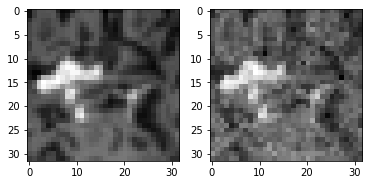

25  :  [0.22679263] 25
50  :  [0.22679263] 25
75  :  [0.28365576] 25
100  :  [0.28365576] 25
125  :  [0.28365576] 25
150  :  [0.28365576] 25
175  :  [0.28646892] 25
200  :  [0.2919265] 25
225  :  [0.30311507] 25
250  :  [0.3039566] 25
275  :  [0.3039566] 25
300  :  [0.31860375] 25
325  :  [0.3196903] 25
350  :  [0.3196903] 25
375  :  [0.3196903] 25
400  :  [0.3214549] 25
425  :  [0.32134974] 25
450  :  [0.32134974] 25
475  :  [0.32134974] 25
500  :  [0.32317126] 25
525  :  [0.32317656] 25
550  :  [0.32317656] 25
575  :  [0.32317656] 25
600  :  [0.32317656] 25
625  :  [0.32723248] 25
650  :  [0.32747304] 25
675  :  [0.32747304] 25
700  :  [0.32747304] 25
725  :  [0.32747304] 25
750  :  [0.32747304] 25
775  :  [0.32747304] 25
800  :  [0.32747304] 25
825  :  [0.32747304] 25
850  :  [0.32747304] 25
875  :  [0.32747304] 25
900  :  [0.32747304] 25
925  :  [0.32747304] 25
950  :  [0.32747304] 25
975  :  [0.32747304] 25
1000  :  [0.32747304] 25
1025  :  [0.32747304] 25
1050  :  [0.32747304] 25

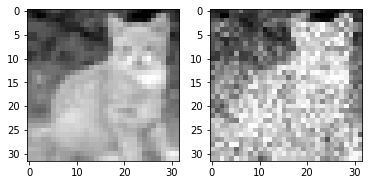

25  :  [0.28286543] 25
50  :  [0.29277492] 25
75  :  [0.29277492] 25
100  :  [0.29277492] 25
125  :  [0.29277492] 25
150  :  [0.29277492] 25
175  :  [0.30079842] 25
200  :  [0.3008492] 25
225  :  [0.3008492] 25
250  :  [0.3097987] 25
275  :  [0.30989456] 25
300  :  [0.31494552] 25
325  :  [0.3149459] 25
350  :  [0.3149459] 25
375  :  [0.31555077] 25
400  :  [0.31745017] 25
425  :  [0.31752974] 25
450  :  [0.31752974] 25
475  :  [0.31752974] 25
500  :  [0.3183615] 25
525  :  [0.32016158] 25
550  :  [0.32016158] 25
575  :  [0.32016158] 25
600  :  [0.32018614] 25
625  :  [0.3210172] 25
650  :  [0.32119697] 25
675  :  [0.32119697] 25
700  :  [0.32119697] 25
725  :  [0.32125783] 25
750  :  [0.32147217] 25
775  :  [0.32172048] 25
800  :  [0.32172048] 25
825  :  [0.32172048] 25
850  :  [0.32172048] 25
875  :  [0.3218329] 25
900  :  [0.3219082] 25
925  :  [0.3220165] 25
950  :  [0.32203835] 25
975  :  [0.32203835] 25
1000  :  [0.32206905] 25
1025  :  [0.3220966] 25
1050  :  [0.32211053] 25
107

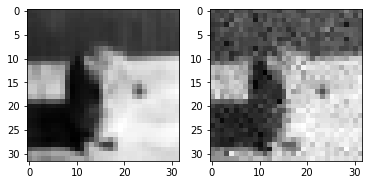

25  :  [0.19741607] 25
50  :  [0.19741607] 25
75  :  [0.25741383] 25
100  :  [0.2379566] 25
125  :  [0.2379566] 25
150  :  [0.2379566] 25
175  :  [0.2379566] 25
200  :  [0.24900477] 25
225  :  [0.2379566] 25
250  :  [0.2524835] 25
275  :  [0.25661165] 25
300  :  [0.2590872] 25
325  :  [0.2590872] 25
350  :  [0.2590872] 25
375  :  [0.2590872] 25
400  :  [0.2669253] 25
425  :  [0.2710026] 25
450  :  [0.27920008] 25
475  :  [0.2828346] 25
500  :  [0.28266877] 25
525  :  [0.28266877] 25
550  :  [0.28266877] 25
575  :  [0.28266877] 25
600  :  [0.28266877] 25
625  :  [0.28267822] 25
650  :  [0.28327763] 25
675  :  [0.28327763] 25
700  :  [0.28481466] 25
725  :  [0.28518045] 25
750  :  [0.28627074] 25
775  :  [0.28627074] 25
800  :  [0.28969854] 25
825  :  [0.2900117] 25
850  :  [0.29482722] 25
875  :  [0.29482722] 25
900  :  [0.29482722] 25
925  :  [0.29482722] 25
950  :  [0.29482722] 25
975  :  [0.29482722] 25
1000  :  [0.29482722] 25
1025  :  [0.29482722] 25
1050  :  [0.29488873] 25
1075  

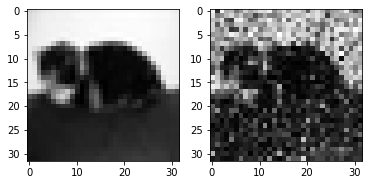

25  :  [0.29423457] 25
50  :  [0.30576056] 25
75  :  [0.30937153] 25
100  :  [0.3445437] 25
125  :  [0.35564464] 25
150  :  [0.35564464] 25
175  :  [0.35564464] 25
200  :  [0.35564464] 25
225  :  [0.35564464] 25
250  :  [0.35564464] 25
275  :  [0.35564464] 25
300  :  [0.35639116] 25
325  :  [0.35911083] 25
350  :  [0.36051148] 25
375  :  [0.36101186] 25
400  :  [0.36101186] 25
425  :  [0.36101186] 25
450  :  [0.36101186] 25
475  :  [0.36113906] 25
500  :  [0.36113906] 25
525  :  [0.36113906] 25
550  :  [0.36113906] 25
575  :  [0.36113906] 25
600  :  [0.36113906] 25
625  :  [0.3617341] 25
650  :  [0.3617341] 25
675  :  [0.3617341] 25
700  :  [0.3617341] 25
725  :  [0.3617341] 25
750  :  [0.36205876] 25
775  :  [0.36205876] 25
800  :  [0.3623985] 25
825  :  [0.3623985] 25
850  :  [0.3623985] 25
875  :  [0.363271] 25
900  :  [0.363271] 25
925  :  [0.363271] 25
950  :  [0.363271] 25
975  :  [0.363271] 25
1000  :  [0.36344868] 25
1025  :  [0.36344868] 25
1050  :  [0.36344868] 25
1075  :  [0

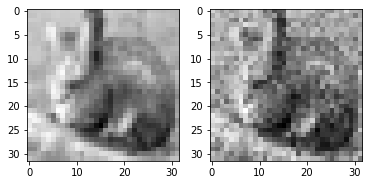

25  :  [0.07413921] 25
50  :  [0.07413921] 25
75  :  [0.09771448] 25
100  :  [0.15333328] 25
125  :  [0.1659837] 25
150  :  [0.17016655] 25
175  :  [0.19752988] 25
200  :  [0.19981521] 25
225  :  [0.19981521] 25
250  :  [0.19984463] 25
275  :  [0.20214483] 25
300  :  [0.21921387] 25
325  :  [0.22755507] 25
350  :  [0.2247518] 25
375  :  [0.2247518] 25
400  :  [0.2341955] 25
425  :  [0.2341955] 25
450  :  [0.23679128] 25
475  :  [0.23742154] 25
500  :  [0.23833415] 25
525  :  [0.23846734] 25
550  :  [0.23875716] 25
575  :  [0.23876917] 25
600  :  [0.23876917] 25
625  :  [0.23933566] 25
650  :  [0.24000618] 25
675  :  [0.2405144] 25
700  :  [0.2407198] 25
725  :  [0.2407198] 25
750  :  [0.2413165] 25
775  :  [0.24131727] 25
800  :  [0.24131727] 25
825  :  [0.24131727] 25
850  :  [0.24131727] 25
875  :  [0.24131727] 25
900  :  [0.24141333] 25
925  :  [0.24159396] 25
950  :  [0.24163988] 25
975  :  [0.24163988] 25
1000  :  [0.24167925] 25
1025  :  [0.24169365] 25
1050  :  [0.24173573] 25
1

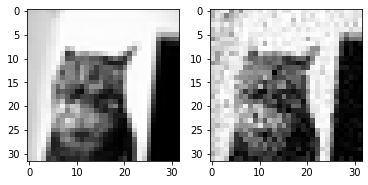

25  :  [0.36629975] 25
50  :  [0.37543502] 25
75  :  [0.37650037] 25
100  :  [0.37650037] 25
125  :  [0.37799752] 25
150  :  [0.37807262] 25
175  :  [0.38001758] 25
200  :  [0.38001758] 25
225  :  [0.38072485] 25
250  :  [0.38072485] 25
275  :  [0.38072485] 25
300  :  [0.3811733] 25
325  :  [0.3811733] 25
350  :  [0.3811733] 25
375  :  [0.38136792] 25
400  :  [0.38136792] 25
425  :  [0.38136792] 25
450  :  [0.38136792] 25
FOUND!  475  :  [0.38196945] 25
Time:  123.74799633026123  seconds
Predicted class:  [2]


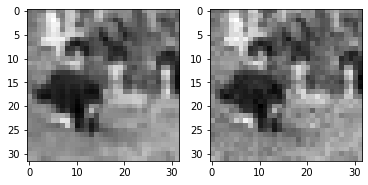

25  :  [0.36862552] 25
50  :  [0.36862552] 25
75  :  [0.37248456] 25
100  :  [0.3725124] 25
125  :  [0.3725124] 25
150  :  [0.37369552] 25
175  :  [0.37385958] 25
200  :  [0.37457588] 25
225  :  [0.37455624] 25
250  :  [0.37455624] 25
275  :  [0.37455624] 25
300  :  [0.37455624] 25
325  :  [0.37488002] 25
350  :  [0.37491128] 25
375  :  [0.37518504] 25
400  :  [0.37542987] 25
425  :  [0.37542987] 25
450  :  [0.37542987] 25
475  :  [0.37542987] 25
500  :  [0.3755434] 25
525  :  [0.3755434] 25
550  :  [0.3755434] 25
575  :  [0.3755434] 25
600  :  [0.3755434] 25
625  :  [0.37561718] 25
650  :  [0.3758207] 25
675  :  [0.3758207] 25
700  :  [0.3758207] 25
725  :  [0.3758207] 25
750  :  [0.37589684] 25
775  :  [0.3759311] 25
800  :  [0.37600228] 25
825  :  [0.37600228] 25
850  :  [0.37600228] 25
875  :  [0.37602544] 25
900  :  [0.37602544] 25
NOT IMPROVING!  925  :  [0.37602544] 25
Time:  238.9847719669342  seconds
Predicted class:  [6]


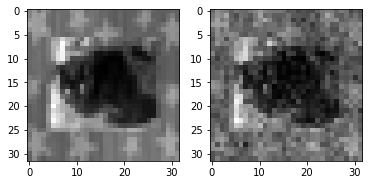

25  :  [-0.21098311] 25
50  :  [-0.02749397] 25
75  :  [0.29590645] 25
100  :  [0.28717273] 25
125  :  [0.3005631] 25
150  :  [0.29214162] 25
175  :  [0.34251136] 25
200  :  [0.34351996] 25
225  :  [0.34351996] 25
250  :  [0.34351996] 25
275  :  [0.34351996] 25
300  :  [0.3461731] 25
325  :  [0.34639806] 25
350  :  [0.34700376] 25
375  :  [0.3470778] 25
400  :  [0.3470778] 25
425  :  [0.3499784] 25
450  :  [0.3499784] 25
475  :  [0.3499784] 25
500  :  [0.3499784] 25
525  :  [0.35034037] 25
550  :  [0.35116062] 25
575  :  [0.35116062] 25
600  :  [0.351799] 25
625  :  [0.35196427] 25
650  :  [0.35196427] 25
675  :  [0.35196427] 25
700  :  [0.35196427] 25
725  :  [0.35196427] 25
750  :  [0.3521888] 25
775  :  [0.35250792] 25
800  :  [0.35250792] 25
825  :  [0.35250792] 25
850  :  [0.35267246] 25
875  :  [0.35282713] 25
900  :  [0.3530327] 25
925  :  [0.3530327] 25
950  :  [0.3530327] 25
975  :  [0.3530686] 25
1000  :  [0.35317105] 25
1025  :  [0.35317105] 25
1050  :  [0.35327733] 25
1075 

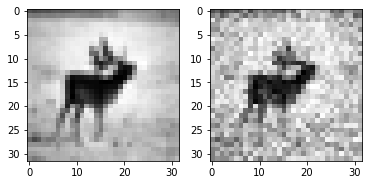

25  :  [0.27658862] 25
50  :  [0.28638583] 25
75  :  [0.24337769] 25
100  :  [0.26469195] 25
125  :  [0.2863628] 25
150  :  [0.2863628] 25
175  :  [0.28876626] 25
200  :  [0.3107515] 25
225  :  [0.313231] 25
250  :  [0.31348473] 25
275  :  [0.3151361] 25
300  :  [0.3166101] 25
325  :  [0.3224321] 25
350  :  [0.3241089] 25
375  :  [0.32413775] 25
400  :  [0.32421225] 25
425  :  [0.3244269] 25
450  :  [0.32576495] 25
475  :  [0.32651] 25
500  :  [0.32884416] 25
525  :  [0.32884416] 25
550  :  [0.32884416] 25
575  :  [0.32900697] 25
600  :  [0.32903808] 25
625  :  [0.33006376] 25
650  :  [0.33006376] 25
675  :  [0.33006376] 25
700  :  [0.33027387] 25
725  :  [0.33032835] 25
750  :  [0.33032835] 25
775  :  [0.33044755] 25
800  :  [0.33044946] 25
825  :  [0.33048958] 25
850  :  [0.33060452] 25
875  :  [0.33081332] 25
900  :  [0.33081332] 25
925  :  [0.33082196] 25
950  :  [0.33091807] 25
975  :  [0.33091807] 25
1000  :  [0.3309653] 25
1025  :  [0.33098674] 25
1050  :  [0.33100608] 25
1075  

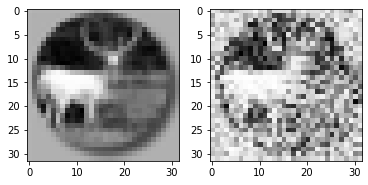

25  :  [0.41205385] 25
50  :  [0.41504192] 25
75  :  [0.41504192] 25
100  :  [0.41504192] 25
125  :  [0.41504192] 25
150  :  [0.41788593] 25
175  :  [0.41788593] 25
200  :  [0.41898277] 25
225  :  [0.42024803] 25
250  :  [0.42024803] 25
275  :  [0.42024803] 25
300  :  [0.42119518] 25
325  :  [0.42119518] 25
350  :  [0.42119518] 25
375  :  [0.42233402] 25
400  :  [0.42306826] 25
425  :  [0.42315733] 25
450  :  [0.4232397] 25
475  :  [0.4235604] 25
500  :  [0.4236692] 25
525  :  [0.4236692] 25
550  :  [0.4236692] 25
575  :  [0.4236692] 25
600  :  [0.4236692] 25
625  :  [0.42375633] 25
650  :  [0.42380044] 25
675  :  [0.42380044] 25
700  :  [0.42381907] 25
725  :  [0.42381907] 25
750  :  [0.42382354] 25
775  :  [0.42390284] 25
800  :  [0.42393517] 25
825  :  [0.42396984] 25
850  :  [0.42400962] 25
875  :  [0.42400962] 25
900  :  [0.42400962] 25
925  :  [0.4240311] 25
950  :  [0.4240311] 25
975  :  [0.42404786] 25
1000  :  [0.42404786] 25
1025  :  [0.42405283] 25
1050  :  [0.42405945] 25
1

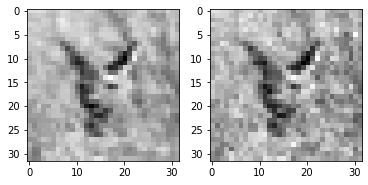

25  :  [0.320792] 25
50  :  [0.3281989] 25
75  :  [0.34459227] 25
100  :  [0.34373325] 25
125  :  [0.3461041] 25
150  :  [0.3460438] 25
175  :  [0.3460438] 25
200  :  [0.3460438] 25
225  :  [0.3460438] 25
250  :  [0.3460438] 25
275  :  [0.3460438] 25
300  :  [0.3460438] 25
325  :  [0.3460438] 25
350  :  [0.3460438] 25
375  :  [0.3460438] 25
400  :  [0.3460438] 25
425  :  [0.3460438] 25
450  :  [0.3460438] 25
475  :  [0.34727585] 25
500  :  [0.34727585] 25
525  :  [0.34730875] 25
550  :  [0.3505764] 25
575  :  [0.3505764] 25
600  :  [0.35108435] 25
625  :  [0.35108435] 25
650  :  [0.35327506] 25
675  :  [0.3534093] 25
700  :  [0.35363293] 25
725  :  [0.35363293] 25
750  :  [0.35461578] 25
775  :  [0.35461578] 25
800  :  [0.35461578] 25
825  :  [0.35461578] 25
850  :  [0.35479045] 25
875  :  [0.3548502] 25
900  :  [0.3548615] 25
925  :  [0.3550002] 25
950  :  [0.3550002] 25
975  :  [0.35504216] 25
1000  :  [0.35504216] 25
1025  :  [0.35504216] 25
1050  :  [0.35506967] 25
1075  :  [0.3550

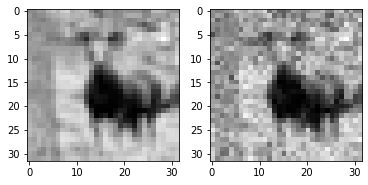

25  :  [0.45158854] 25
50  :  [0.4520212] 25
75  :  [0.45416987] 25
100  :  [0.4552722] 25
125  :  [0.4552722] 25
150  :  [0.4552722] 25
175  :  [0.45874056] 25
200  :  [0.45874056] 25
225  :  [0.45874056] 25
250  :  [0.45926943] 25
275  :  [0.46041083] 25
300  :  [0.46153829] 25
325  :  [0.46162224] 25
350  :  [0.46227914] 25
375  :  [0.4628355] 25
400  :  [0.4638456] 25
FOUND!  425  :  [0.46411952] 25
Time:  111.00181794166565  seconds
Predicted class:  [2]


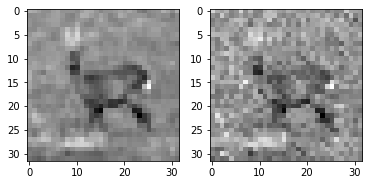

25  :  [0.41092035] 25
50  :  [0.41092035] 25
75  :  [0.41017354] 25
100  :  [0.41017354] 25
125  :  [0.41017354] 25
150  :  [0.41017354] 25
175  :  [0.41017354] 25
200  :  [0.41017354] 25
225  :  [0.4136677] 25
250  :  [0.4146868] 25
275  :  [0.41466808] 25
300  :  [0.4194296] 25
325  :  [0.4194296] 25
350  :  [0.4194296] 25
375  :  [0.4194296] 25
400  :  [0.4194296] 25
425  :  [0.4194296] 25
450  :  [0.4194296] 25
475  :  [0.4194296] 25
500  :  [0.4194296] 25
525  :  [0.4194296] 25
550  :  [0.4222326] 25
575  :  [0.4225907] 25
600  :  [0.4225907] 25
625  :  [0.4225907] 25
650  :  [0.4225907] 25
675  :  [0.4230407] 25
700  :  [0.42571124] 25
725  :  [0.42571124] 25
750  :  [0.42571124] 25
775  :  [0.4262553] 25
800  :  [0.42731833] 25
825  :  [0.42731833] 25
850  :  [0.4283699] 25
875  :  [0.4283699] 25
900  :  [0.4286901] 25
925  :  [0.42925394] 25
950  :  [0.42925394] 25
975  :  [0.42942423] 25
1000  :  [0.42961678] 25
1025  :  [0.42961678] 25
1050  :  [0.42973426] 25
1075  :  [0.42

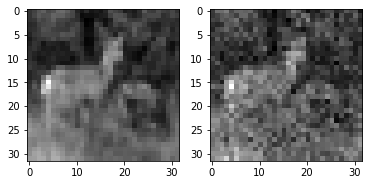

25  :  [0.3095419] 25
50  :  [0.3095419] 25
75  :  [0.3095419] 25
100  :  [0.3095419] 25
125  :  [0.3095419] 25
150  :  [0.31046763] 25
175  :  [0.31046763] 25
200  :  [0.31046763] 25
225  :  [0.31126976] 25
250  :  [0.31230074] 25
275  :  [0.3122607] 25
300  :  [0.3122607] 25
325  :  [0.31291908] 25
350  :  [0.31292474] 25
375  :  [0.31315246] 25
400  :  [0.31332535] 25
425  :  [0.31351623] 25
450  :  [0.31370592] 25
475  :  [0.31435984] 25
500  :  [0.3144729] 25
525  :  [0.31506473] 25
550  :  [0.31508055] 25
575  :  [0.31508055] 25
600  :  [0.31515622] 25
625  :  [0.31520233] 25
650  :  [0.31571072] 25
675  :  [0.31592092] 25
700  :  [0.3159495] 25
725  :  [0.31623048] 25
750  :  [0.3162703] 25
775  :  [0.31645995] 25
800  :  [0.31657034] 25
825  :  [0.31662625] 25
850  :  [0.31673193] 25
875  :  [0.31682366] 25
900  :  [0.31706092] 25
925  :  [0.3170631] 25
950  :  [0.3171756] 25
975  :  [0.3171756] 25
1000  :  [0.3171756] 25
NOT IMPROVING!  1025  :  [0.31720042] 25
Time:  277.9568

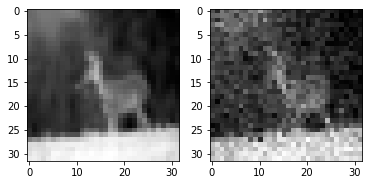

25  :  [0.15744676] 25
50  :  [0.15744676] 25
75  :  [0.1787301] 25
100  :  [0.2869893] 25
125  :  [0.28174132] 25
150  :  [0.28174132] 25
175  :  [0.28174132] 25
200  :  [0.28174132] 25
225  :  [0.28174132] 25
250  :  [0.28174132] 25
275  :  [0.28174132] 25
300  :  [0.28174132] 25
325  :  [0.28174132] 25
350  :  [0.29600558] 25
375  :  [0.29600558] 25
400  :  [0.29600558] 25
425  :  [0.29600558] 25
450  :  [0.29600558] 25
475  :  [0.29600558] 25
500  :  [0.29600558] 25
525  :  [0.29600558] 25
550  :  [0.29600558] 25
575  :  [0.29600558] 25
600  :  [0.29600558] 25
625  :  [0.29600558] 25
650  :  [0.29653576] 25
675  :  [0.29600558] 25
700  :  [0.29600558] 25
725  :  [0.29600558] 25
750  :  [0.29600558] 25
775  :  [0.29600558] 25
800  :  [0.29600558] 25
825  :  [0.29600558] 25
850  :  [0.29600558] 25
875  :  [0.29600558] 25
900  :  [0.29600558] 25
925  :  [0.29600558] 25
950  :  [0.29600558] 25
975  :  [0.29600558] 25
1000  :  [0.29600558] 25
1025  :  [0.29600558] 25
1050  :  [0.2960055

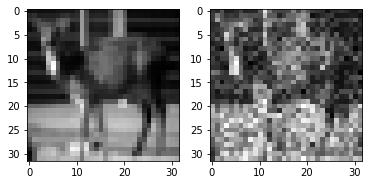

25  :  [0.34720176] 25
50  :  [0.34857357] 25
75  :  [0.35658455] 25
100  :  [0.35645372] 25
125  :  [0.35840768] 25
150  :  [0.35844886] 25
175  :  [0.35844886] 25
200  :  [0.35844886] 25
225  :  [0.35844886] 25
250  :  [0.35990202] 25
275  :  [0.35996985] 25
300  :  [0.35996985] 25
325  :  [0.35996985] 25
350  :  [0.35996985] 25
375  :  [0.35996985] 25
400  :  [0.36096546] 25
425  :  [0.36107367] 25
450  :  [0.36107367] 25
475  :  [0.3614001] 25
500  :  [0.36157343] 25
525  :  [0.36157343] 25
550  :  [0.36157343] 25
575  :  [0.36157343] 25
600  :  [0.36157343] 25
625  :  [0.36160254] 25
650  :  [0.36160254] 25
675  :  [0.36160254] 25
700  :  [0.36221308] 25
725  :  [0.36344388] 25
750  :  [0.36344388] 25
775  :  [0.3643747] 25
800  :  [0.3643747] 25
825  :  [0.3643747] 25
850  :  [0.3643747] 25
875  :  [0.3643747] 25
900  :  [0.36507356] 25
925  :  [0.36507356] 25
950  :  [0.36507356] 25
975  :  [0.3651323] 25
1000  :  [0.3651416] 25
1025  :  [0.3651416] 25
1050  :  [0.36555958] 25
1

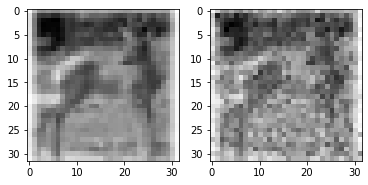

25  :  [0.32847583] 25
50  :  [0.32847583] 25
75  :  [0.32984817] 25
100  :  [0.33031815] 25
125  :  [0.33031815] 25
150  :  [0.33190387] 25
175  :  [0.3319568] 25
200  :  [0.3319568] 25
225  :  [0.3319568] 25
250  :  [0.3319568] 25
275  :  [0.3332077] 25
300  :  [0.3332243] 25
325  :  [0.3332243] 25
350  :  [0.3332243] 25
375  :  [0.33472344] 25
400  :  [0.33472344] 25
425  :  [0.33472344] 25
450  :  [0.33472344] 25
475  :  [0.33472344] 25
500  :  [0.33480093] 25
525  :  [0.33533347] 25
550  :  [0.33533347] 25
575  :  [0.33533347] 25
600  :  [0.33533347] 25
625  :  [0.33552146] 25
650  :  [0.3355914] 25
675  :  [0.3355914] 25
700  :  [0.3355914] 25
725  :  [0.3355914] 25
750  :  [0.3355914] 25
775  :  [0.3355914] 25
800  :  [0.3355914] 25
825  :  [0.3355914] 25
850  :  [0.3355914] 25
875  :  [0.3355914] 25
900  :  [0.3355914] 25
925  :  [0.3355914] 25
950  :  [0.3355914] 25
975  :  [0.3355914] 25
1000  :  [0.3355914] 25
1025  :  [0.3355914] 25
1050  :  [0.3355914] 25
1075  :  [0.33559

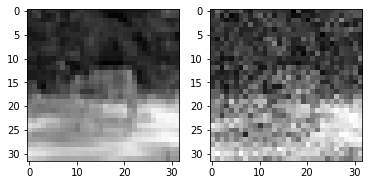

25  :  [0.39067703] 25
50  :  [0.39067703] 25
75  :  [0.3907822] 25
100  :  [0.39193928] 25
125  :  [0.3930429] 25
150  :  [0.3943621] 25
175  :  [0.3943621] 25
200  :  [0.39523268] 25
225  :  [0.39523268] 25
250  :  [0.39523268] 25
275  :  [0.39523268] 25
300  :  [0.39523268] 25
325  :  [0.39561763] 25
FOUND!  350  :  [0.3960565] 25
Time:  94.78084421157837  seconds
Predicted class:  [2]


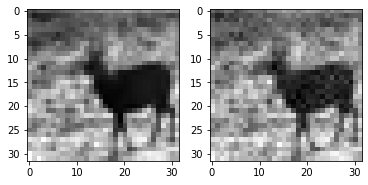

25  :  [0.40381783] 25
50  :  [0.40796494] 25
75  :  [0.41004002] 25
100  :  [0.41004002] 25
125  :  [0.41004002] 25
150  :  [0.41004002] 25
175  :  [0.41004002] 25
200  :  [0.41004002] 25
225  :  [0.41004002] 25
250  :  [0.41004002] 25
275  :  [0.41148397] 25
300  :  [0.41148397] 25
325  :  [0.41148397] 25
350  :  [0.41148397] 25
375  :  [0.41148397] 25
400  :  [0.41148397] 25
425  :  [0.4119549] 25
450  :  [0.4119549] 25
475  :  [0.4119549] 25
500  :  [0.4119549] 25
525  :  [0.4119549] 25
550  :  [0.4119549] 25
575  :  [0.41300622] 25
600  :  [0.41300622] 25
625  :  [0.41300622] 25
650  :  [0.4131856] 25
675  :  [0.4131856] 25
700  :  [0.41348162] 25
725  :  [0.41348162] 25
750  :  [0.41348162] 25
775  :  [0.41348162] 25
800  :  [0.4139228] 25
825  :  [0.4139228] 25
850  :  [0.4139228] 25
875  :  [0.4139228] 25
900  :  [0.41401744] 25
925  :  [0.41401744] 25
950  :  [0.4140694] 25
975  :  [0.4140694] 25
1000  :  [0.41441873] 25
1025  :  [0.41441873] 25
1050  :  [0.41450894] 25
1075  

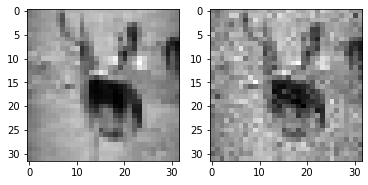

25  :  [0.37516692] 25
50  :  [0.39413226] 25
75  :  [0.39413226] 25
100  :  [0.4018073] 25
125  :  [0.4018073] 25
150  :  [0.4018073] 25
175  :  [0.4018073] 25
200  :  [0.4018073] 25
225  :  [0.4018073] 25
250  :  [0.4018073] 25
275  :  [0.40464053] 25
300  :  [0.40464053] 25
325  :  [0.40464053] 25
350  :  [0.40464053] 25
375  :  [0.40505806] 25
400  :  [0.40505806] 25
425  :  [0.40505806] 25
450  :  [0.40505806] 25
475  :  [0.40505806] 25
500  :  [0.40505806] 25
525  :  [0.40505806] 25
550  :  [0.40505806] 25
575  :  [0.40505806] 25
600  :  [0.40505806] 25
625  :  [0.40505806] 25
650  :  [0.40505806] 25
675  :  [0.40505806] 25
700  :  [0.40505806] 25
725  :  [0.40505806] 25
750  :  [0.40505806] 25
775  :  [0.40505806] 25
800  :  [0.40505806] 25
825  :  [0.40505806] 25
850  :  [0.40505806] 25
875  :  [0.40505806] 25
900  :  [0.40505806] 25
925  :  [0.40505806] 25
950  :  [0.40505806] 25
975  :  [0.40505806] 25
1000  :  [0.40505806] 25
1025  :  [0.40505806] 25
NOT IMPROVING!  1050  : 

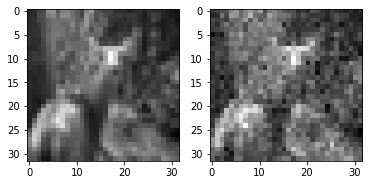

25  :  [0.443078] 25
50  :  [0.443078] 25
75  :  [0.44391158] 25
100  :  [0.44391158] 25
125  :  [0.4446307] 25
150  :  [0.4446307] 25
175  :  [0.4446307] 25
200  :  [0.4446307] 25
225  :  [0.4446307] 25
250  :  [0.4446307] 25
FOUND!  275  :  [0.44500744] 25
Time:  72.4158706665039  seconds
Predicted class:  [2]


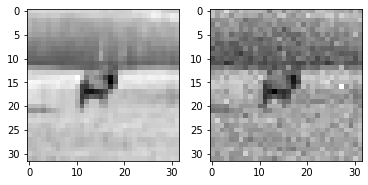

25  :  [0.35949668] 25
50  :  [0.35949668] 25
75  :  [0.35949668] 25
100  :  [0.35949668] 25
125  :  [0.35967812] 25
150  :  [0.37104544] 25
175  :  [0.37104544] 25
200  :  [0.37104544] 25
225  :  [0.37117782] 25
250  :  [0.37421304] 25
275  :  [0.37421304] 25
300  :  [0.37692723] 25
325  :  [0.37692723] 25
350  :  [0.37692723] 25
375  :  [0.37950248] 25
400  :  [0.37973818] 25
425  :  [0.38231236] 25
450  :  [0.38231236] 25
475  :  [0.38231236] 25
500  :  [0.38231236] 25
525  :  [0.38407093] 25
550  :  [0.38407093] 25
575  :  [0.38407093] 25
600  :  [0.38407093] 25
625  :  [0.38407093] 25
650  :  [0.38407093] 25
675  :  [0.38407093] 25
700  :  [0.38407093] 25
725  :  [0.38447058] 25
750  :  [0.38507476] 25
775  :  [0.38507476] 25
800  :  [0.38512903] 25
825  :  [0.38512903] 25
850  :  [0.38516167] 25
875  :  [0.38596982] 25
900  :  [0.38623473] 25
925  :  [0.38679248] 25
950  :  [0.38679248] 25
975  :  [0.38679248] 25
1000  :  [0.38679248] 25
1025  :  [0.38709366] 25
1050  :  [0.38709

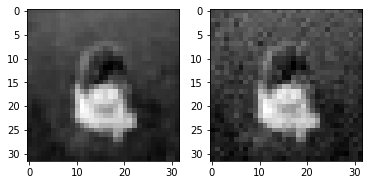

25  :  [0.22039148] 25
50  :  [0.22914575] 25
75  :  [0.3209373] 25
100  :  [0.34116733] 25
125  :  [0.34638217] 25
150  :  [0.36282915] 25
175  :  [0.36282915] 25
200  :  [0.36653176] 25
225  :  [0.36679763] 25
250  :  [0.36679763] 25
275  :  [0.37103093] 25
300  :  [0.37103093] 25
325  :  [0.37103093] 25
350  :  [0.3767221] 25
375  :  [0.3767221] 25
400  :  [0.38191408] 25
425  :  [0.38477466] 25
450  :  [0.38477466] 25
475  :  [0.38477466] 25
500  :  [0.38477466] 25
525  :  [0.38477466] 25
550  :  [0.3849628] 25
575  :  [0.38537395] 25
600  :  [0.38537395] 25
625  :  [0.38667262] 25
650  :  [0.38667262] 25
675  :  [0.38667262] 25
700  :  [0.38699293] 25
725  :  [0.38734376] 25
750  :  [0.38746154] 25
775  :  [0.38786215] 25
800  :  [0.38786215] 25
825  :  [0.38786215] 25
850  :  [0.38786215] 25
875  :  [0.38787526] 25
900  :  [0.3879558] 25
925  :  [0.3879558] 25
950  :  [0.3880325] 25
975  :  [0.38803744] 25
1000  :  [0.388173] 25
1025  :  [0.38818502] 25
1050  :  [0.3882926] 25
10

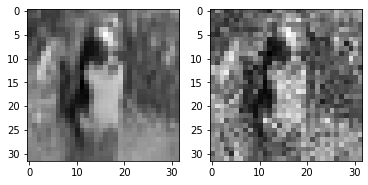

25  :  [0.35872316] 25
50  :  [0.3605678] 25
75  :  [0.36303288] 25
100  :  [0.36394477] 25
125  :  [0.36508796] 25
150  :  [0.36509836] 25
175  :  [0.36509836] 25
200  :  [0.36509836] 25
225  :  [0.36509836] 25
250  :  [0.36509836] 25
275  :  [0.3652257] 25
300  :  [0.3652619] 25
325  :  [0.3652619] 25
350  :  [0.36616907] 25
375  :  [0.36616907] 25
400  :  [0.36618102] 25
425  :  [0.36619765] 25
450  :  [0.36628008] 25
475  :  [0.36643153] 25
500  :  [0.36707488] 25
525  :  [0.36710715] 25
550  :  [0.36710715] 25
575  :  [0.36710715] 25
600  :  [0.36712474] 25
625  :  [0.36726803] 25
650  :  [0.36729226] 25
675  :  [0.36729226] 25
700  :  [0.36765665] 25
725  :  [0.36765665] 25
750  :  [0.36765665] 25
775  :  [0.36765665] 25
800  :  [0.36772975] 25
825  :  [0.3677354] 25
850  :  [0.36782095] 25
875  :  [0.36795557] 25
NOT IMPROVING!  900  :  [0.36802232] 25
Time:  245.65674114227295  seconds
Predicted class:  [2]


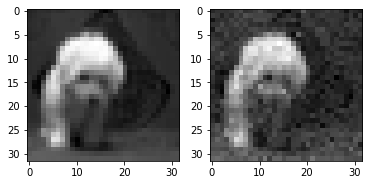

25  :  [0.3442595] 25
50  :  [0.3442595] 25
75  :  [0.34374392] 25
100  :  [0.34374392] 25
125  :  [0.34374392] 25
150  :  [0.34483707] 25
175  :  [0.34755713] 25
200  :  [0.34767926] 25
225  :  [0.34767926] 25
250  :  [0.35023588] 25
275  :  [0.3503293] 25
300  :  [0.3503293] 25
325  :  [0.3503293] 25
350  :  [0.3503293] 25
375  :  [0.35130128] 25
400  :  [0.35132223] 25
425  :  [0.35193855] 25
450  :  [0.35271025] 25
475  :  [0.35277355] 25
500  :  [0.35277355] 25
525  :  [0.3532198] 25
550  :  [0.3532198] 25
575  :  [0.3532198] 25
600  :  [0.3532198] 25
625  :  [0.35322946] 25
650  :  [0.35322946] 25
675  :  [0.35338542] 25
700  :  [0.35358143] 25
725  :  [0.35358143] 25
750  :  [0.35379055] 25
775  :  [0.3537922] 25
800  :  [0.3537922] 25
825  :  [0.353836] 25
850  :  [0.3538854] 25
875  :  [0.3538854] 25
900  :  [0.35389045] 25
925  :  [0.35396695] 25
950  :  [0.35404605] 25
975  :  [0.3540486] 25
1000  :  [0.35412127] 25
NOT IMPROVING!  1025  :  [0.35420483] 25
Time:  273.7196009

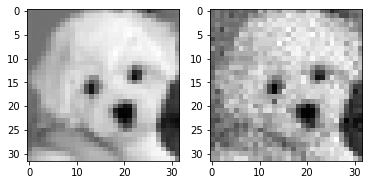

25  :  [0.35988006] 25
50  :  [0.35988006] 25
75  :  [0.35988006] 25
100  :  [0.35988006] 25
125  :  [0.35988006] 25
150  :  [0.36103153] 25
175  :  [0.3610422] 25
200  :  [0.3610422] 25
225  :  [0.3611186] 25
250  :  [0.3611186] 25
275  :  [0.36125642] 25
300  :  [0.36138588] 25
325  :  [0.36148328] 25
350  :  [0.36148468] 25
375  :  [0.36148468] 25
400  :  [0.36177072] 25
425  :  [0.36219862] 25
450  :  [0.36219862] 25
475  :  [0.36259535] 25
500  :  [0.36259535] 25
525  :  [0.36259535] 25
550  :  [0.36266804] 25
575  :  [0.3627408] 25
600  :  [0.36287487] 25
625  :  [0.36303145] 25
650  :  [0.36303145] 25
675  :  [0.36303717] 25
700  :  [0.36312914] 25
725  :  [0.36322325] 25
750  :  [0.36331344] 25
775  :  [0.36340535] 25
800  :  [0.36346555] 25
825  :  [0.36350995] 25
850  :  [0.36350995] 25
875  :  [0.36350995] 25
900  :  [0.36351925] 25
NOT IMPROVING!  925  :  [0.3635316] 25
Time:  245.71491289138794  seconds
Predicted class:  [2]


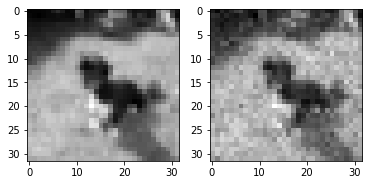

25  :  [0.38335198] 25
50  :  [0.38335198] 25
75  :  [0.38476366] 25
100  :  [0.38493472] 25
125  :  [0.38676375] 25
150  :  [0.38676375] 25
175  :  [0.38676375] 25
200  :  [0.3890908] 25
225  :  [0.3890908] 25
250  :  [0.3890908] 25
275  :  [0.3890908] 25
300  :  [0.38930863] 25
325  :  [0.38934427] 25
350  :  [0.38948566] 25
375  :  [0.39007145] 25
400  :  [0.39007145] 25
425  :  [0.3901709] 25
450  :  [0.3901709] 25
475  :  [0.3901709] 25
500  :  [0.39037603] 25
525  :  [0.39037603] 25
550  :  [0.39074385] 25
575  :  [0.39074385] 25
600  :  [0.39074385] 25
625  :  [0.39074385] 25
650  :  [0.39074385] 25
675  :  [0.39080548] 25
700  :  [0.3908096] 25
725  :  [0.3908096] 25
750  :  [0.39088342] 25
775  :  [0.39091507] 25
800  :  [0.39095068] 25
825  :  [0.39095503] 25
850  :  [0.39101353] 25
875  :  [0.391036] 25
900  :  [0.3910658] 25
925  :  [0.3910658] 25
950  :  [0.3910658] 25
NOT IMPROVING!  975  :  [0.39109236] 25
Time:  263.7624764442444  seconds
Predicted class:  [2]


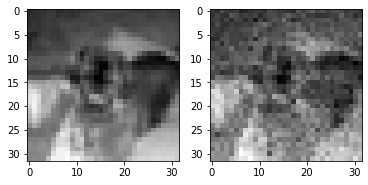

25  :  [0.33718365] 25
50  :  [0.33718365] 25
75  :  [0.34537035] 25
100  :  [0.3452858] 25
125  :  [0.3452858] 25
150  :  [0.3452858] 25
175  :  [0.3452858] 25
200  :  [0.3452858] 25
225  :  [0.3452858] 25
250  :  [0.3452858] 25
275  :  [0.3452858] 25
300  :  [0.3452858] 25
325  :  [0.3452858] 25
350  :  [0.3452858] 25
375  :  [0.3452858] 25
400  :  [0.3452858] 25
425  :  [0.3452858] 25
450  :  [0.3452858] 25
475  :  [0.3452858] 25
500  :  [0.3452858] 25
525  :  [0.3452858] 25
550  :  [0.3452858] 25
575  :  [0.3452858] 25
600  :  [0.3452858] 25
625  :  [0.3452858] 25
650  :  [0.3452858] 25
675  :  [0.3452858] 25
700  :  [0.3452858] 25
725  :  [0.3452858] 25
750  :  [0.3452858] 25
775  :  [0.3452858] 25
800  :  [0.3452858] 25
825  :  [0.3452858] 25
NOT IMPROVING!  850  :  [0.3452858] 25
Time:  225.98342633247375  seconds
Predicted class:  [2]


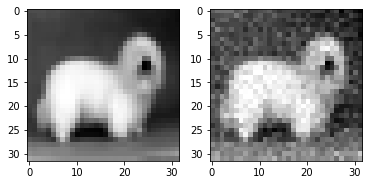

25  :  [0.25142205] 25
50  :  [0.25142205] 25
75  :  [0.32472852] 25
100  :  [0.3248875] 25
125  :  [0.3246645] 25
150  :  [0.3246645] 25
175  :  [0.3306312] 25
200  :  [0.3311383] 25
225  :  [0.3311383] 25
250  :  [0.3311383] 25
275  :  [0.3311383] 25
300  :  [0.33194992] 25
325  :  [0.33194992] 25
350  :  [0.33194992] 25
375  :  [0.33194992] 25
400  :  [0.33194992] 25
425  :  [0.33194992] 25
450  :  [0.33194992] 25
475  :  [0.33605206] 25
500  :  [0.33605206] 25
525  :  [0.33605206] 25
550  :  [0.33605206] 25
575  :  [0.33625534] 25
600  :  [0.33626786] 25
625  :  [0.33626786] 25
650  :  [0.3380025] 25
675  :  [0.3380025] 25
700  :  [0.3380025] 25
725  :  [0.3380025] 25
750  :  [0.3380025] 25
775  :  [0.3380025] 25
800  :  [0.33833048] 25
825  :  [0.338514] 25
850  :  [0.33860934] 25
875  :  [0.33860934] 25
900  :  [0.33860934] 25
925  :  [0.33860934] 25
950  :  [0.33860934] 25
975  :  [0.33884937] 25
1000  :  [0.33884937] 25
1025  :  [0.33899796] 25
1050  :  [0.33921975] 25
1075  : 

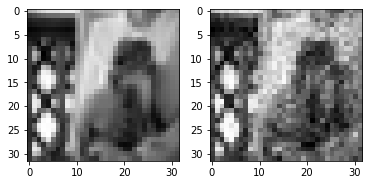

25  :  [0.14619601] 25
50  :  [0.14619601] 25
75  :  [0.25738177] 25
100  :  [0.29453772] 25
125  :  [0.29442775] 25
150  :  [0.29442775] 25
175  :  [0.29442775] 25
200  :  [0.29442775] 25
225  :  [0.2959237] 25
250  :  [0.29593387] 25
275  :  [0.29593387] 25
300  :  [0.29593387] 25
325  :  [0.29593387] 25
350  :  [0.29593387] 25
375  :  [0.29593387] 25
400  :  [0.29593387] 25
425  :  [0.29593387] 25
450  :  [0.29593387] 25
475  :  [0.29593387] 25
500  :  [0.29593387] 25
525  :  [0.29593387] 25
550  :  [0.29593387] 25
575  :  [0.29593387] 25
600  :  [0.29593387] 25
625  :  [0.29649198] 25
650  :  [0.29621246] 25
675  :  [0.29595238] 25
700  :  [0.29595238] 25
725  :  [0.29609615] 25
750  :  [0.2982083] 25
775  :  [0.29955456] 25
800  :  [0.29955456] 25
825  :  [0.29957446] 25
850  :  [0.29957446] 25
875  :  [0.29957446] 25
900  :  [0.3008139] 25
925  :  [0.3008139] 25
950  :  [0.3008139] 25
975  :  [0.30176136] 25
1000  :  [0.30176136] 25
1025  :  [0.30176136] 25
1050  :  [0.30218256] 

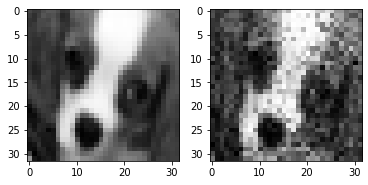

25  :  [0.31319502] 25
50  :  [0.31319502] 25
75  :  [0.32332593] 25
100  :  [0.32806736] 25
125  :  [0.33284646] 25
150  :  [0.3353933] 25
175  :  [0.335256] 25
200  :  [0.335256] 25
225  :  [0.335256] 25
250  :  [0.335256] 25
275  :  [0.335256] 25
300  :  [0.335256] 25
325  :  [0.335256] 25
350  :  [0.335256] 25
375  :  [0.335256] 25
400  :  [0.335256] 25
425  :  [0.3355983] 25
450  :  [0.3355239] 25
475  :  [0.33739585] 25
500  :  [0.3376468] 25
525  :  [0.3409258] 25
550  :  [0.3409258] 25
575  :  [0.3409258] 25
600  :  [0.34102684] 25
625  :  [0.34261245] 25
650  :  [0.34261245] 25
675  :  [0.34264624] 25
700  :  [0.34264624] 25
725  :  [0.34264624] 25
750  :  [0.34269765] 25
775  :  [0.34271878] 25
800  :  [0.3427549] 25
825  :  [0.34280324] 25
850  :  [0.34281647] 25
875  :  [0.34295538] 25
900  :  [0.34308264] 25
925  :  [0.34308943] 25
950  :  [0.34308943] 25
975  :  [0.3430901] 25
1000  :  [0.3430901] 25
1025  :  [0.34309852] 25
1050  :  [0.34314197] 25
1075  :  [0.34316564] 

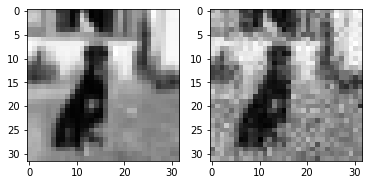

25  :  [0.20422646] 25
50  :  [0.26585388] 25
75  :  [0.27707154] 25
100  :  [0.2775385] 25
125  :  [0.27967548] 25
150  :  [0.28221002] 25
175  :  [0.28345776] 25
200  :  [0.28947014] 25
225  :  [0.2900238] 25
250  :  [0.2900238] 25
275  :  [0.2900238] 25
300  :  [0.2911141] 25
325  :  [0.29261506] 25
350  :  [0.29260093] 25
375  :  [0.29260093] 25
400  :  [0.29297316] 25
425  :  [0.29362756] 25
450  :  [0.2939554] 25
475  :  [0.29436213] 25
500  :  [0.29449564] 25
525  :  [0.29449564] 25
550  :  [0.29459336] 25
575  :  [0.29469573] 25
600  :  [0.29469573] 25
625  :  [0.29484642] 25
650  :  [0.29494882] 25
675  :  [0.29502934] 25
700  :  [0.2950529] 25
725  :  [0.29513004] 25
750  :  [0.29516843] 25
775  :  [0.29518694] 25
800  :  [0.29522684] 25
825  :  [0.29531604] 25
850  :  [0.29537493] 25
875  :  [0.29542285] 25
900  :  [0.29544535] 25
925  :  [0.29554135] 25
950  :  [0.2955427] 25
975  :  [0.29555044] 25
1000  :  [0.29555702] 25
1025  :  [0.29559302] 25
1050  :  [0.29559568] 25


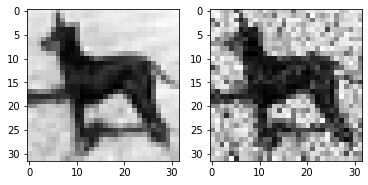

25  :  [0.24840723] 25
50  :  [0.24840723] 25
75  :  [0.26652557] 25
100  :  [0.26668024] 25
125  :  [0.26668024] 25
150  :  [0.26668024] 25
175  :  [0.26668024] 25
200  :  [0.26668024] 25
225  :  [0.26668024] 25
250  :  [0.26668024] 25
275  :  [0.26668024] 25
300  :  [0.26668024] 25
325  :  [0.26668024] 25
350  :  [0.26668024] 25
375  :  [0.26668024] 25
400  :  [0.26668024] 25
425  :  [0.26668024] 25
450  :  [0.26668024] 25
475  :  [0.26668024] 25
500  :  [0.26668024] 25
525  :  [0.26668024] 25
550  :  [0.2685657] 25
575  :  [0.2685657] 25
600  :  [0.2685657] 25
625  :  [0.2685657] 25
650  :  [0.26964095] 25
675  :  [0.26964095] 25
700  :  [0.26964095] 25
725  :  [0.26994485] 25
750  :  [0.26994485] 25
775  :  [0.26995134] 25
800  :  [0.27074796] 25
825  :  [0.27074796] 25
850  :  [0.27074796] 25
875  :  [0.27074796] 25
900  :  [0.27095854] 25
925  :  [0.27095854] 25
950  :  [0.27114493] 25
975  :  [0.27114493] 25
1000  :  [0.27118465] 25
1025  :  [0.27121943] 25
1050  :  [0.27131647]

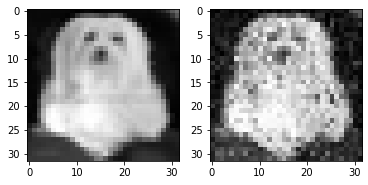

25  :  [0.20016983] 25
50  :  [0.20469691] 25
75  :  [0.23693486] 25
100  :  [0.21715835] 25
125  :  [0.2200888] 25
150  :  [0.23030214] 25
175  :  [0.2611321] 25
200  :  [0.26022443] 25
225  :  [0.26236245] 25
250  :  [0.2639599] 25
275  :  [0.26409924] 25
300  :  [0.26409924] 25
325  :  [0.26409924] 25
350  :  [0.26409924] 25
375  :  [0.2645916] 25
400  :  [0.2649918] 25
425  :  [0.26568902] 25
450  :  [0.26677683] 25
475  :  [0.2668712] 25
500  :  [0.2668712] 25
525  :  [0.2668712] 25
550  :  [0.2668712] 25
575  :  [0.2668712] 25
600  :  [0.26697147] 25
625  :  [0.26702803] 25
650  :  [0.26702785] 25
675  :  [0.26740468] 25
700  :  [0.26740468] 25
725  :  [0.26745108] 25
750  :  [0.2675637] 25
775  :  [0.2676063] 25
800  :  [0.26787907] 25
825  :  [0.26795387] 25
850  :  [0.26815355] 25
875  :  [0.26815355] 25
900  :  [0.2681546] 25
925  :  [0.26817906] 25
950  :  [0.26817906] 25
975  :  [0.2682329] 25
1000  :  [0.26823694] 25
1025  :  [0.26826185] 25
1050  :  [0.2683347] 25
1075  :

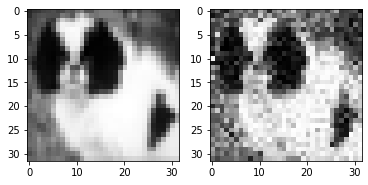

25  :  [0.3514845] 25
50  :  [0.35154855] 25
75  :  [0.35241103] 25
100  :  [0.3524524] 25
125  :  [0.3524524] 25
150  :  [0.3524524] 25
175  :  [0.3524524] 25
200  :  [0.35255063] 25
225  :  [0.35276455] 25
250  :  [0.35381693] 25
275  :  [0.3538592] 25
300  :  [0.3538919] 25
325  :  [0.3538919] 25
350  :  [0.35390082] 25
375  :  [0.35390306] 25
400  :  [0.3539085] 25
425  :  [0.353994] 25
450  :  [0.35434297] 25
475  :  [0.35451823] 25
500  :  [0.35451823] 25
525  :  [0.35451823] 25
550  :  [0.35451823] 25
575  :  [0.3545264] 25
600  :  [0.35457408] 25
625  :  [0.35466492] 25
650  :  [0.35472554] 25
675  :  [0.35477543] 25
700  :  [0.3549437] 25
725  :  [0.3549586] 25
750  :  [0.3551293] 25
775  :  [0.35515958] 25
800  :  [0.3552032] 25
825  :  [0.35527092] 25
850  :  [0.355352] 25
875  :  [0.3555184] 25
900  :  [0.35555226] 25
925  :  [0.35558915] 25
950  :  [0.3556463] 25
975  :  [0.35570353] 25
1000  :  [0.35584736] 25
NOT IMPROVING!  1025  :  [0.35584736] 25
Time:  269.8990640640

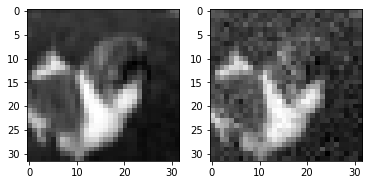

25  :  [-0.08240597] 25
50  :  [-0.08240597] 25
75  :  [0.02358797] 25
100  :  [0.09675354] 25
125  :  [0.18058407] 25
150  :  [0.18058407] 25
175  :  [0.18914445] 25
200  :  [0.18914445] 25
225  :  [0.20197663] 25
250  :  [0.22802344] 25
275  :  [0.22802344] 25
300  :  [0.22802344] 25
325  :  [0.22802344] 25
350  :  [0.23140067] 25
375  :  [0.23140067] 25
400  :  [0.23140067] 25
425  :  [0.23140067] 25
450  :  [0.25830138] 25
475  :  [0.23140067] 25
500  :  [0.23166993] 25
525  :  [0.23202217] 25
550  :  [0.2382354] 25
575  :  [0.2382354] 25
600  :  [0.2382354] 25
625  :  [0.2382354] 25
650  :  [0.2382354] 25
675  :  [0.2382354] 25
700  :  [0.2382354] 25
725  :  [0.2382354] 25
750  :  [0.24529457] 25
775  :  [0.26057822] 25
800  :  [0.26075494] 25
825  :  [0.26265085] 25
850  :  [0.26265085] 25
875  :  [0.27160323] 25
900  :  [0.2716849] 25
925  :  [0.2716849] 25
950  :  [0.2716849] 25
975  :  [0.2716849] 25
1000  :  [0.27423656] 25
1025  :  [0.29333007] 25
1050  :  [0.29333007] 25
10

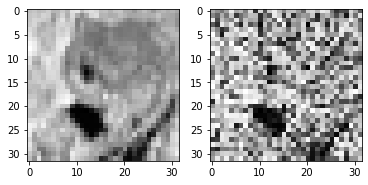

25  :  [0.22525612] 25
50  :  [0.31192183] 25
75  :  [0.3082224] 25
100  :  [0.3498265] 25
125  :  [0.3493433] 25
150  :  [0.3493433] 25
175  :  [0.3493433] 25
200  :  [0.3493433] 25
225  :  [0.3493433] 25
250  :  [0.3493433] 25
275  :  [0.3493433] 25
300  :  [0.3493433] 25
325  :  [0.3493433] 25
350  :  [0.3493433] 25
375  :  [0.3493433] 25
400  :  [0.3493433] 25
425  :  [0.3493433] 25
450  :  [0.3493433] 25
475  :  [0.3493433] 25
500  :  [0.3493433] 25
525  :  [0.3493433] 25
550  :  [0.3493433] 25
575  :  [0.3493433] 25
600  :  [0.3493433] 25
625  :  [0.3493433] 25
650  :  [0.3493433] 25
675  :  [0.3493433] 25
700  :  [0.3493433] 25
725  :  [0.3493433] 25
750  :  [0.3493433] 25
775  :  [0.3493433] 25
800  :  [0.3493433] 25
825  :  [0.3493433] 25
850  :  [0.3493433] 25
NOT IMPROVING!  875  :  [0.3493433] 25
Time:  235.8927891254425  seconds
Predicted class:  [2]


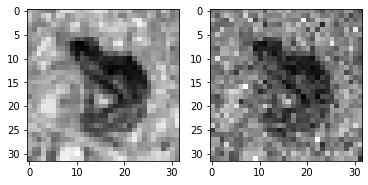

25  :  [0.39020553] 25
50  :  [0.39020553] 25
75  :  [0.39511144] 25
100  :  [0.39511144] 25
125  :  [0.39511144] 25
150  :  [0.40455005] 25
175  :  [0.40455005] 25
200  :  [0.41149902] 25
225  :  [0.41149902] 25
250  :  [0.413404] 25
275  :  [0.413404] 25
300  :  [0.41935015] 25
325  :  [0.41935015] 25
350  :  [0.41935015] 25
375  :  [0.42093647] 25
400  :  [0.42278448] 25
425  :  [0.42530483] 25
450  :  [0.42539454] 25
475  :  [0.42619815] 25
500  :  [0.42619815] 25
525  :  [0.42619815] 25
550  :  [0.42676196] 25
575  :  [0.426971] 25
600  :  [0.42702472] 25
625  :  [0.42736813] 25
650  :  [0.42736813] 25
675  :  [0.42769742] 25
700  :  [0.42769742] 25
725  :  [0.4278534] 25
750  :  [0.4278534] 25
775  :  [0.4278534] 25
800  :  [0.4279086] 25
825  :  [0.42798376] 25
850  :  [0.4280666] 25
875  :  [0.42811245] 25
900  :  [0.42813003] 25
925  :  [0.42817965] 25
950  :  [0.42820936] 25
975  :  [0.42830884] 25
1000  :  [0.42843443] 25
1025  :  [0.42843443] 25
1050  :  [0.42847648] 25
107

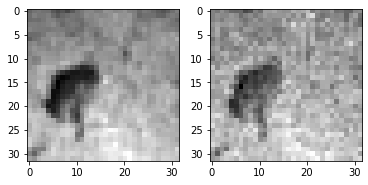

25  :  [-0.30680817] 25
50  :  [0.21787262] 25
75  :  [0.1470666] 25
100  :  [0.1470666] 25
125  :  [0.1470666] 25
150  :  [0.1470666] 25
175  :  [0.15265156] 25
200  :  [0.23382099] 25
225  :  [0.23382099] 25
250  :  [0.23382099] 25
275  :  [0.23382099] 25
300  :  [0.23382099] 25
325  :  [0.23731798] 25
350  :  [0.24564452] 25
375  :  [0.25408238] 25
400  :  [0.25515038] 25
425  :  [0.25525793] 25
450  :  [0.2820385] 25
475  :  [0.2820385] 25
500  :  [0.2820385] 25
525  :  [0.29281944] 25
550  :  [0.29374108] 25
575  :  [0.29374108] 25
600  :  [0.29374108] 25
625  :  [0.2940963] 25
650  :  [0.29986656] 25
675  :  [0.29986656] 25
700  :  [0.30513978] 25
725  :  [0.30513978] 25
750  :  [0.30664903] 25
775  :  [0.30664903] 25
800  :  [0.311818] 25
825  :  [0.311818] 25
850  :  [0.311818] 25
875  :  [0.31626847] 25
900  :  [0.3177175] 25
925  :  [0.32093284] 25
950  :  [0.32093284] 25
975  :  [0.32272452] 25
1000  :  [0.3227539] 25
1025  :  [0.32286435] 25
1050  :  [0.32376188] 25
1075  :

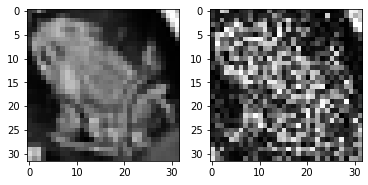

25  :  [0.24002226] 25
50  :  [0.24002226] 25
75  :  [0.2976434] 25
100  :  [0.30914664] 25
125  :  [0.3108895] 25
150  :  [0.3108895] 25
175  :  [0.3147949] 25
200  :  [0.32312515] 25
225  :  [0.32312515] 25
250  :  [0.33740348] 25
275  :  [0.33740348] 25
300  :  [0.33740348] 25
325  :  [0.33740348] 25
350  :  [0.33740348] 25
375  :  [0.33740348] 25
400  :  [0.33740348] 25
425  :  [0.33740348] 25
450  :  [0.33740348] 25
475  :  [0.33740348] 25
500  :  [0.3391037] 25
525  :  [0.34007448] 25
550  :  [0.34007448] 25
575  :  [0.34007448] 25
600  :  [0.3467563] 25
625  :  [0.34743267] 25
650  :  [0.3514723] 25
675  :  [0.35121816] 25
700  :  [0.35411042] 25
725  :  [0.35499933] 25
750  :  [0.35508734] 25
775  :  [0.35529596] 25
800  :  [0.356053] 25
825  :  [0.35641858] 25
850  :  [0.3570485] 25
875  :  [0.3570485] 25
900  :  [0.3570485] 25
925  :  [0.35800534] 25
950  :  [0.35917312] 25
975  :  [0.35917312] 25
1000  :  [0.3591758] 25
1025  :  [0.3591758] 25
1050  :  [0.3593749] 25
1075  :

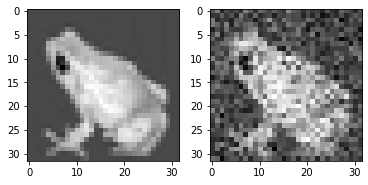

25  :  [0.12484153] 25
50  :  [0.17344688] 25
75  :  [0.08210221] 25
100  :  [0.28503835] 25
125  :  [0.2855304] 25
150  :  [0.2855304] 25
175  :  [0.28603435] 25
200  :  [0.28603435] 25
225  :  [0.28603435] 25
250  :  [0.28603435] 25
275  :  [0.28603435] 25
300  :  [0.28603435] 25
325  :  [0.28603435] 25
350  :  [0.28603435] 25
375  :  [0.28630945] 25
400  :  [0.2883919] 25
425  :  [0.2883919] 25
450  :  [0.2883919] 25
475  :  [0.28897816] 25
500  :  [0.29285967] 25
525  :  [0.29367778] 25
550  :  [0.29367778] 25
575  :  [0.29367778] 25
600  :  [0.29367778] 25
625  :  [0.29577255] 25
650  :  [0.29577255] 25
675  :  [0.29622212] 25
700  :  [0.29622212] 25
725  :  [0.29622212] 25
750  :  [0.29623246] 25
775  :  [0.29684818] 25
800  :  [0.2983691] 25
825  :  [0.29847437] 25
850  :  [0.29847437] 25
875  :  [0.29847437] 25
900  :  [0.29847437] 25
925  :  [0.29847437] 25
950  :  [0.29865474] 25
975  :  [0.2999515] 25
1000  :  [0.2999515] 25
1025  :  [0.2999515] 25
1050  :  [0.2999515] 25
10

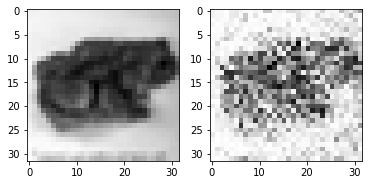

25  :  [0.25918755] 25
50  :  [0.25918755] 25
75  :  [0.2897697] 25
100  :  [0.28979176] 25
125  :  [0.28979176] 25
150  :  [0.28979176] 25
175  :  [0.28979176] 25
200  :  [0.33806023] 25
225  :  [0.33806023] 25
250  :  [0.33806023] 25
275  :  [0.33806023] 25
300  :  [0.33806023] 25
325  :  [0.33806023] 25
350  :  [0.33806023] 25
375  :  [0.33806023] 25
400  :  [0.33806023] 25
425  :  [0.33806023] 25
450  :  [0.3406494] 25
475  :  [0.34632224] 25
500  :  [0.34864676] 25
525  :  [0.34864676] 25
550  :  [0.34864676] 25
575  :  [0.34864676] 25
600  :  [0.3537928] 25
625  :  [0.3537928] 25
650  :  [0.35379744] 25
675  :  [0.35379744] 25
700  :  [0.3553347] 25
725  :  [0.3554004] 25
750  :  [0.35754177] 25
775  :  [0.35754177] 25
800  :  [0.35835627] 25
825  :  [0.35835627] 25
850  :  [0.35835627] 25
875  :  [0.35835627] 25
900  :  [0.35835627] 25
925  :  [0.35862947] 25
950  :  [0.35869348] 25
975  :  [0.35870904] 25
1000  :  [0.3590632] 25
1025  :  [0.3593071] 25
1050  :  [0.3593071] 25
1

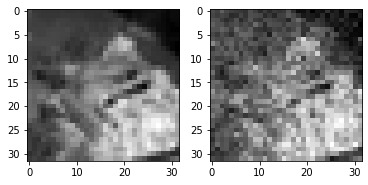

25  :  [0.06559777] 25
50  :  [0.06559777] 25
75  :  [0.19041453] 25
100  :  [0.22616698] 25
125  :  [0.22616698] 25
150  :  [0.22616698] 25
175  :  [0.2671094] 25
200  :  [0.27926934] 25
225  :  [0.27137142] 25
250  :  [0.27137142] 25
275  :  [0.27566257] 25
300  :  [0.28870046] 25
325  :  [0.28870046] 25
350  :  [0.29104164] 25
375  :  [0.2918983] 25
400  :  [0.30706835] 25
425  :  [0.30860746] 25
450  :  [0.3087029] 25
475  :  [0.30903512] 25
500  :  [0.30903512] 25
525  :  [0.30903512] 25
550  :  [0.30931395] 25
575  :  [0.3123263] 25
600  :  [0.3123514] 25
625  :  [0.3185489] 25
650  :  [0.3185489] 25
675  :  [0.3185489] 25
700  :  [0.3185489] 25
725  :  [0.3185489] 25
750  :  [0.32030293] 25
775  :  [0.32030293] 25
800  :  [0.32030293] 25
825  :  [0.3248506] 25
850  :  [0.32490438] 25
875  :  [0.3257197] 25
900  :  [0.3257197] 25
925  :  [0.3257197] 25
950  :  [0.3257197] 25
975  :  [0.3257197] 25
1000  :  [0.3257197] 25
1025  :  [0.3266092] 25
1050  :  [0.3269031] 25
1075  :  [0

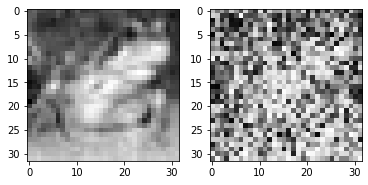

25  :  [0.02292781] 25
50  :  [0.14898723] 25
75  :  [0.15281269] 25
100  :  [0.197306] 25
125  :  [0.15281269] 25
150  :  [0.20851322] 25
175  :  [0.27548504] 25
200  :  [0.2017173] 25
225  :  [0.23770672] 25
250  :  [0.23770672] 25
275  :  [0.28992784] 25
300  :  [0.27567816] 25
325  :  [0.27900687] 25
350  :  [0.28018516] 25
375  :  [0.29518735] 25
400  :  [0.29518735] 25
425  :  [0.3126356] 25
450  :  [0.3126356] 25
475  :  [0.31783402] 25
500  :  [0.31783402] 25
525  :  [0.31931823] 25
550  :  [0.3322811] 25
575  :  [0.33244228] 25
600  :  [0.33244228] 25
625  :  [0.33244228] 25
650  :  [0.33244228] 25
675  :  [0.34037778] 25
700  :  [0.34196138] 25
725  :  [0.34196138] 25
750  :  [0.34196138] 25
775  :  [0.34196138] 25
800  :  [0.3446546] 25
825  :  [0.34663922] 25
850  :  [0.3469441] 25
875  :  [0.34894282] 25
900  :  [0.35035396] 25
925  :  [0.35089475] 25
950  :  [0.35089475] 25
975  :  [0.3517797] 25
1000  :  [0.35217023] 25
1025  :  [0.35217023] 25
1050  :  [0.35217023] 25
1

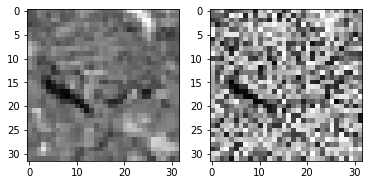

25  :  [-0.08365692] 25
50  :  [-0.08365692] 25
75  :  [0.25160933] 25
100  :  [0.25160933] 25
125  :  [0.25160933] 25
150  :  [0.25160933] 25
175  :  [0.25160933] 25
200  :  [0.25160933] 25
225  :  [0.25160933] 25
250  :  [0.25160933] 25
275  :  [0.25160933] 25
300  :  [0.29356915] 25
325  :  [0.3001781] 25
350  :  [0.2883407] 25
375  :  [0.2883407] 25
400  :  [0.2883407] 25
425  :  [0.2888469] 25
450  :  [0.2888469] 25
475  :  [0.2888469] 25
500  :  [0.29709357] 25
525  :  [0.29693025] 25
550  :  [0.301594] 25
575  :  [0.31036806] 25
600  :  [0.30669662] 25
625  :  [0.3107058] 25
650  :  [0.3107058] 25
675  :  [0.31071135] 25
700  :  [0.32134143] 25
725  :  [0.3350848] 25
750  :  [0.33561623] 25
775  :  [0.33561623] 25
800  :  [0.33561623] 25
825  :  [0.33561623] 25
850  :  [0.33561623] 25
875  :  [0.3359042] 25
900  :  [0.33959162] 25
925  :  [0.341996] 25
950  :  [0.34346402] 25
975  :  [0.3450466] 25
1000  :  [0.34533164] 25
1025  :  [0.34533164] 25
1050  :  [0.3472224] 25
1075  :

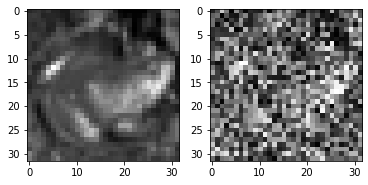

25  :  [-0.00332518] 25
50  :  [0.1451069] 25
75  :  [0.17428897] 25
100  :  [0.22111265] 25
125  :  [0.20657502] 25
150  :  [0.24558325] 25
175  :  [0.26156664] 25
200  :  [0.26156664] 25
225  :  [0.26156664] 25
250  :  [0.26156664] 25
275  :  [0.26156664] 25
300  :  [0.26156664] 25
325  :  [0.27190888] 25
350  :  [0.2904982] 25
375  :  [0.29572415] 25
400  :  [0.2981633] 25
425  :  [0.30257133] 25
450  :  [0.30257133] 25
475  :  [0.30257133] 25
500  :  [0.30257133] 25
525  :  [0.30257133] 25
550  :  [0.30257133] 25
575  :  [0.30306602] 25
600  :  [0.30259746] 25
625  :  [0.30259746] 25
650  :  [0.3048473] 25
675  :  [0.30491662] 25
700  :  [0.31354344] 25
725  :  [0.3168776] 25
750  :  [0.31694347] 25
775  :  [0.31730428] 25
800  :  [0.31732562] 25
825  :  [0.31839868] 25
850  :  [0.31839868] 25
875  :  [0.31995016] 25
900  :  [0.32049268] 25
925  :  [0.32523286] 25
950  :  [0.3250001] 25
975  :  [0.3253077] 25
1000  :  [0.32666823] 25
1025  :  [0.32681262] 25
1050  :  [0.33063966] 2

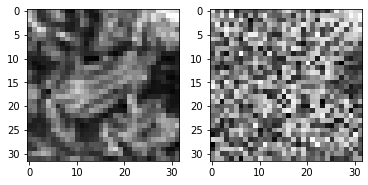

25  :  [-0.09588127] 25
50  :  [-0.09588127] 25
75  :  [0.23764025] 25
100  :  [0.242507] 25
125  :  [0.26000935] 25
150  :  [0.26000935] 25
175  :  [0.26000935] 25
200  :  [0.26000935] 25
225  :  [0.26000935] 25
250  :  [0.26000935] 25
275  :  [0.26000935] 25
300  :  [0.26000935] 25
325  :  [0.26353413] 25
350  :  [0.2617101] 25
375  :  [0.27799886] 25
400  :  [0.27783775] 25
425  :  [0.3051679] 25
450  :  [0.3224777] 25
475  :  [0.3235551] 25
500  :  [0.33151948] 25
525  :  [0.33151948] 25
550  :  [0.3318974] 25
575  :  [0.33219934] 25
600  :  [0.32541385] 25
625  :  [0.32541385] 25
650  :  [0.32541385] 25
675  :  [0.32541385] 25
700  :  [0.32541385] 25
725  :  [0.3263155] 25
750  :  [0.33017695] 25
775  :  [0.34101164] 25
800  :  [0.34041232] 25
825  :  [0.3459307] 25
850  :  [0.3473915] 25
875  :  [0.3487012] 25
900  :  [0.3495046] 25
925  :  [0.35298222] 25
950  :  [0.35576135] 25
975  :  [0.35645837] 25
1000  :  [0.35645837] 25
1025  :  [0.36126688] 25
1050  :  [0.36181733] 25
10

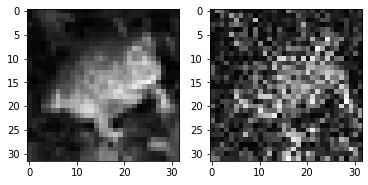

25  :  [0.04017602] 25
50  :  [0.09698592] 25
75  :  [-0.00375172] 25
100  :  [0.1694639] 25
125  :  [0.18957567] 25
150  :  [0.18957567] 25
175  :  [0.18957567] 25
200  :  [0.18957567] 25
225  :  [0.18957567] 25
250  :  [0.18957567] 25
275  :  [0.18957567] 25
300  :  [0.24563637] 25
325  :  [0.2172764] 25
350  :  [0.25208148] 25
375  :  [0.2873507] 25
400  :  [0.2873507] 25
425  :  [0.2873507] 25
450  :  [0.28792864] 25
475  :  [0.28792864] 25
500  :  [0.28792864] 25
525  :  [0.28792864] 25
550  :  [0.3050927] 25
575  :  [0.3107232] 25
600  :  [0.31907594] 25
625  :  [0.31929877] 25
650  :  [0.31929877] 25
675  :  [0.3200748] 25
700  :  [0.32426935] 25
725  :  [0.3251315] 25
750  :  [0.32521337] 25
775  :  [0.32667863] 25
800  :  [0.32667863] 25
825  :  [0.3269512] 25
850  :  [0.32713217] 25
875  :  [0.327166] 25
900  :  [0.327166] 25
925  :  [0.32773852] 25
950  :  [0.3286689] 25
975  :  [0.3286689] 25
1000  :  [0.3286689] 25
1025  :  [0.32880157] 25
1050  :  [0.32880157] 25
1075  : 

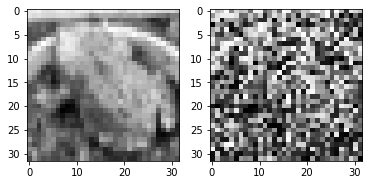

25  :  [0.23934801] 25
50  :  [0.23934801] 25
75  :  [0.21125649] 25
100  :  [0.22833733] 25
125  :  [0.24742897] 25
150  :  [0.25762618] 25
175  :  [0.2795667] 25
200  :  [0.2795667] 25
225  :  [0.28025487] 25
250  :  [0.28025487] 25
275  :  [0.28025487] 25
300  :  [0.2871182] 25
325  :  [0.2871182] 25
350  :  [0.28726596] 25
375  :  [0.28902823] 25
400  :  [0.28943703] 25
425  :  [0.29194832] 25
450  :  [0.29268795] 25
475  :  [0.29286265] 25
500  :  [0.29286265] 25
525  :  [0.2930035] 25
550  :  [0.2930035] 25
575  :  [0.2930035] 25
600  :  [0.29427522] 25
625  :  [0.2946022] 25
650  :  [0.2947953] 25
675  :  [0.2947953] 25
700  :  [0.29514688] 25
725  :  [0.29514688] 25
750  :  [0.2957607] 25
775  :  [0.29647893] 25
800  :  [0.29647893] 25
825  :  [0.29744083] 25
850  :  [0.29782772] 25
875  :  [0.29782772] 25
900  :  [0.29927266] 25
925  :  [0.29935783] 25
950  :  [0.29935783] 25
975  :  [0.29959798] 25
1000  :  [0.29985857] 25
1025  :  [0.2998888] 25
1050  :  [0.30029902] 25
1075

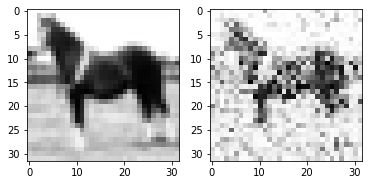

25  :  [0.28438333] 25
50  :  [0.28864977] 25
75  :  [0.30172783] 25
100  :  [0.30192927] 25
125  :  [0.30192927] 25
150  :  [0.30213362] 25
175  :  [0.3036602] 25
200  :  [0.3040406] 25
225  :  [0.3040406] 25
250  :  [0.30480462] 25
275  :  [0.30511275] 25
300  :  [0.30511275] 25
325  :  [0.30511275] 25
350  :  [0.30557132] 25
375  :  [0.3055802] 25
400  :  [0.3055802] 25
425  :  [0.305708] 25
450  :  [0.30627406] 25
475  :  [0.30707902] 25
500  :  [0.30707902] 25
525  :  [0.30707902] 25
550  :  [0.30707902] 25
575  :  [0.30707902] 25
600  :  [0.30760694] 25
625  :  [0.30760694] 25
650  :  [0.30760694] 25
675  :  [0.30784017] 25
700  :  [0.30785704] 25
725  :  [0.30785704] 25
750  :  [0.30803865] 25
775  :  [0.30803865] 25
800  :  [0.30803865] 25
825  :  [0.30817854] 25
850  :  [0.30823743] 25
875  :  [0.30828682] 25
900  :  [0.30828682] 25
925  :  [0.30828682] 25
NOT IMPROVING!  950  :  [0.30832362] 25
Time:  235.33075523376465  seconds
Predicted class:  [6]


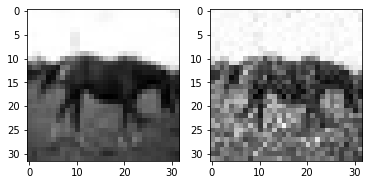

25  :  [0.30124724] 25
50  :  [0.31401896] 25
75  :  [0.31989706] 25
100  :  [0.3201965] 25
125  :  [0.3201965] 25
150  :  [0.3201965] 25
175  :  [0.3201965] 25
200  :  [0.32109675] 25
225  :  [0.32105625] 25
250  :  [0.32105625] 25
275  :  [0.32105625] 25
300  :  [0.32278842] 25
325  :  [0.3227949] 25
350  :  [0.3227949] 25
375  :  [0.3227949] 25
400  :  [0.3227949] 25
425  :  [0.3227949] 25
450  :  [0.3227949] 25
475  :  [0.3227949] 25
500  :  [0.32283986] 25
525  :  [0.32385206] 25
550  :  [0.32385305] 25
575  :  [0.32385305] 25
600  :  [0.32385305] 25
625  :  [0.32385305] 25
650  :  [0.3239907] 25
675  :  [0.3242749] 25
700  :  [0.3243472] 25
725  :  [0.3244155] 25
750  :  [0.32465738] 25
775  :  [0.32467735] 25
800  :  [0.32467735] 25
825  :  [0.324714] 25
850  :  [0.3248137] 25
875  :  [0.32483155] 25
900  :  [0.3249328] 25
925  :  [0.3249328] 25
950  :  [0.3249328] 25
975  :  [0.324955] 25
1000  :  [0.324955] 25
1025  :  [0.32497364] 25
1050  :  [0.32508647] 25
1075  :  [0.32510

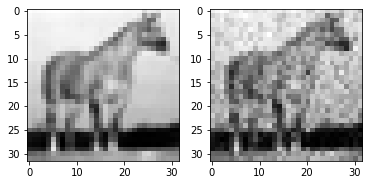

25  :  [0.27471578] 25
50  :  [0.3183878] 25
75  :  [0.32585192] 25
100  :  [0.32321876] 25
125  :  [0.3280183] 25
150  :  [0.3303886] 25
175  :  [0.3313106] 25
200  :  [0.33343244] 25
225  :  [0.33343244] 25
250  :  [0.34185565] 25
275  :  [0.34246266] 25
300  :  [0.34246266] 25
325  :  [0.34246266] 25
350  :  [0.34248415] 25
375  :  [0.34248415] 25
400  :  [0.34424227] 25
425  :  [0.346321] 25
450  :  [0.34647435] 25
475  :  [0.34653544] 25
500  :  [0.3464669] 25
525  :  [0.34702173] 25
550  :  [0.34871453] 25
575  :  [0.34869927] 25
600  :  [0.3503241] 25
625  :  [0.3503428] 25
650  :  [0.3503428] 25
675  :  [0.3503428] 25
700  :  [0.35104024] 25
725  :  [0.35168952] 25
750  :  [0.35168952] 25
775  :  [0.35168952] 25
800  :  [0.3524811] 25
825  :  [0.35329735] 25
850  :  [0.35329735] 25
875  :  [0.35329735] 25
900  :  [0.35329735] 25
925  :  [0.35335356] 25
950  :  [0.35371035] 25
975  :  [0.35377353] 25
1000  :  [0.35378432] 25
1025  :  [0.35399473] 25
1050  :  [0.35401672] 25
1075

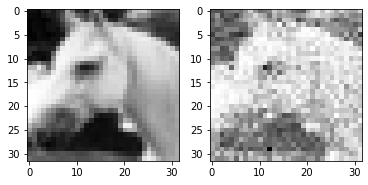

25  :  [0.2922967] 25
50  :  [0.31126976] 25
75  :  [0.31268856] 25
100  :  [0.31268856] 25
125  :  [0.31268856] 25
150  :  [0.31268856] 25
175  :  [0.31268856] 25
200  :  [0.31268856] 25
225  :  [0.31268856] 25
250  :  [0.31548318] 25
275  :  [0.31539848] 25
300  :  [0.31539848] 25
325  :  [0.31539848] 25
350  :  [0.31539848] 25
375  :  [0.31539848] 25
400  :  [0.31539848] 25
425  :  [0.31539848] 25
450  :  [0.31539848] 25
475  :  [0.31539848] 25
500  :  [0.31539848] 25
525  :  [0.31539848] 25
550  :  [0.31539848] 25
575  :  [0.31539848] 25
600  :  [0.31539848] 25
625  :  [0.31539848] 25
650  :  [0.31539848] 25
675  :  [0.31539848] 25
700  :  [0.31539848] 25
725  :  [0.31539848] 25
750  :  [0.31539848] 25
775  :  [0.3167684] 25
800  :  [0.31700152] 25
825  :  [0.3178013] 25
850  :  [0.31877324] 25
875  :  [0.31958443] 25
900  :  [0.32024562] 25
925  :  [0.3202449] 25
950  :  [0.32041252] 25
975  :  [0.32042363] 25
1000  :  [0.32165545] 25
1025  :  [0.32172537] 25
1050  :  [0.32218772]

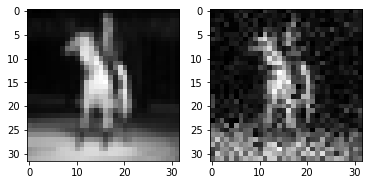

25  :  [0.33440626] 25
50  :  [0.33440626] 25
75  :  [0.33561274] 25
100  :  [0.3379541] 25
125  :  [0.33561274] 25
150  :  [0.34859574] 25
175  :  [0.3492108] 25
200  :  [0.3612683] 25
225  :  [0.36068732] 25
250  :  [0.36068732] 25
275  :  [0.36068732] 25
300  :  [0.36068732] 25
325  :  [0.36068732] 25
350  :  [0.36068732] 25
375  :  [0.36068732] 25
400  :  [0.36068732] 25
425  :  [0.36068732] 25
450  :  [0.36068732] 25
475  :  [0.36068732] 25
500  :  [0.36068732] 25
525  :  [0.36068732] 25
550  :  [0.36068732] 25
575  :  [0.36068732] 25
600  :  [0.36068732] 25
625  :  [0.36068732] 25
650  :  [0.36068732] 25
675  :  [0.36068732] 25
700  :  [0.36068732] 25
725  :  [0.36068732] 25
750  :  [0.36068732] 25
775  :  [0.36068732] 25
800  :  [0.36068732] 25
825  :  [0.36068732] 25
850  :  [0.36068732] 25
875  :  [0.36068732] 25
900  :  [0.36068732] 25
925  :  [0.36068732] 25
950  :  [0.36117375] 25
NOT IMPROVING!  975  :  [0.36117375] 25
Time:  237.75632500648499  seconds
Predicted class:  [

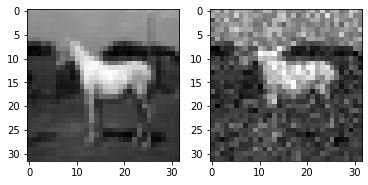

25  :  [0.38106826] 25
50  :  [0.3852626] 25
75  :  [0.38528055] 25
100  :  [0.39222866] 25
125  :  [0.39503637] 25
150  :  [0.3950406] 25
175  :  [0.3950406] 25
200  :  [0.3950406] 25
225  :  [0.3950406] 25
250  :  [0.3981284] 25
275  :  [0.3981284] 25
300  :  [0.3981284] 25
325  :  [0.3981284] 25
350  :  [0.39878502] 25
375  :  [0.39880842] 25
400  :  [0.39897177] 25
425  :  [0.39966327] 25
450  :  [0.40011847] 25
475  :  [0.40064487] 25
500  :  [0.40065923] 25
525  :  [0.40084732] 25
550  :  [0.40084732] 25
575  :  [0.4013082] 25
600  :  [0.4013432] 25
625  :  [0.4013432] 25
650  :  [0.4018708] 25
675  :  [0.4018708] 25
700  :  [0.4018708] 25
725  :  [0.4018708] 25
750  :  [0.40200108] 25
775  :  [0.40208113] 25
800  :  [0.40208113] 25
825  :  [0.40208113] 25
850  :  [0.4021089] 25
875  :  [0.40218687] 25
900  :  [0.40218687] 25
925  :  [0.40218687] 25
950  :  [0.4021973] 25
975  :  [0.40222192] 25
1000  :  [0.40223414] 25
NOT IMPROVING!  1025  :  [0.4022441] 25
Time:  255.291728496

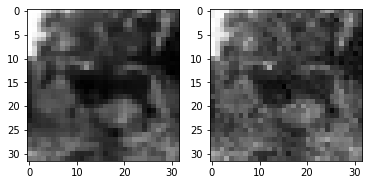

25  :  [0.33610398] 25
50  :  [0.33610398] 25
75  :  [0.33610398] 25
100  :  [0.33665726] 25
125  :  [0.3370902] 25
150  :  [0.33864045] 25
175  :  [0.3400557] 25
200  :  [0.34020954] 25
225  :  [0.3402623] 25
250  :  [0.3405891] 25
275  :  [0.34102583] 25
300  :  [0.34119737] 25
325  :  [0.3412894] 25
350  :  [0.34137556] 25
375  :  [0.34137556] 25
400  :  [0.34137556] 25
425  :  [0.34143472] 25
450  :  [0.34167308] 25
475  :  [0.341865] 25
500  :  [0.3420813] 25
525  :  [0.34233955] 25
550  :  [0.3424366] 25
575  :  [0.34265068] 25
600  :  [0.34266138] 25
625  :  [0.3426643] 25
650  :  [0.34280482] 25
675  :  [0.3428365] 25
700  :  [0.3428365] 25
725  :  [0.3428365] 25
750  :  [0.34288895] 25
775  :  [0.34295663] 25
800  :  [0.34300816] 25
825  :  [0.34312785] 25
850  :  [0.3431366] 25
875  :  [0.34314233] 25
900  :  [0.34314457] 25
925  :  [0.34317216] 25
NOT IMPROVING!  950  :  [0.34320724] 25
Time:  232.41813278198242  seconds
Predicted class:  [6]


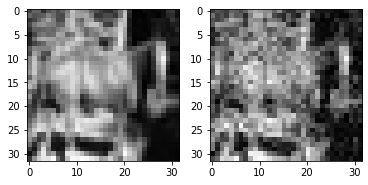

25  :  [0.34973022] 25
50  :  [0.34973022] 25
75  :  [0.34973022] 25
100  :  [0.3503851] 25
125  :  [0.35091192] 25
150  :  [0.35149732] 25
175  :  [0.35143167] 25
200  :  [0.35143167] 25
225  :  [0.3515815] 25
250  :  [0.3515815] 25
275  :  [0.3515815] 25
300  :  [0.35268652] 25
325  :  [0.35351062] 25
350  :  [0.35376632] 25
375  :  [0.35388893] 25
400  :  [0.35416877] 25
425  :  [0.35416877] 25
450  :  [0.35487396] 25
475  :  [0.35487396] 25
500  :  [0.35548747] 25
525  :  [0.35571003] 25
550  :  [0.35571003] 25
575  :  [0.35571003] 25
600  :  [0.35577828] 25
625  :  [0.35577828] 25
650  :  [0.35577828] 25
675  :  [0.35577828] 25
700  :  [0.3557884] 25
725  :  [0.35579467] 25
750  :  [0.35579467] 25
775  :  [0.35579467] 25
800  :  [0.35582748] 25
825  :  [0.35589537] 25
850  :  [0.35589537] 25
875  :  [0.35589868] 25
900  :  [0.35596636] 25
925  :  [0.35598117] 25
950  :  [0.35599875] 25
975  :  [0.35600054] 25
1000  :  [0.35600388] 25
1025  :  [0.35601202] 25
1050  :  [0.35601848] 

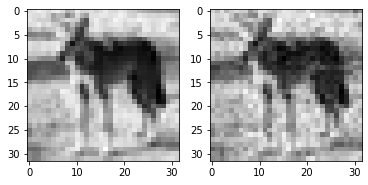

25  :  [0.33548683] 25
50  :  [0.33564532] 25
75  :  [0.33564532] 25
100  :  [0.33594304] 25
FOUND!  125  :  [0.3364023] 25
Time:  29.4095196723938  seconds
Predicted class:  [6]


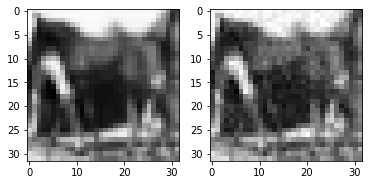

25  :  [0.3237636] 25
50  :  [0.3237636] 25
75  :  [0.32560992] 25
100  :  [0.3254854] 25
125  :  [0.3254854] 25
150  :  [0.3254854] 25
175  :  [0.3254854] 25
200  :  [0.3254854] 25
225  :  [0.3254854] 25
250  :  [0.3254854] 25
275  :  [0.3254854] 25
300  :  [0.3254854] 25
325  :  [0.3257981] 25
350  :  [0.32640487] 25
375  :  [0.3276389] 25
400  :  [0.32763833] 25
425  :  [0.32763833] 25
450  :  [0.3280197] 25
475  :  [0.3280198] 25
500  :  [0.3280198] 25
525  :  [0.3280198] 25
550  :  [0.32816666] 25
575  :  [0.32863498] 25
600  :  [0.32882515] 25
625  :  [0.32918927] 25
650  :  [0.32918927] 25
675  :  [0.32918927] 25
700  :  [0.32918927] 25
725  :  [0.32918927] 25
750  :  [0.32935825] 25
775  :  [0.32935825] 25
800  :  [0.32935825] 25
825  :  [0.32942045] 25
850  :  [0.32944143] 25
875  :  [0.3295332] 25
900  :  [0.3295332] 25
925  :  [0.3295334] 25
950  :  [0.32953978] 25
975  :  [0.32953978] 25
1000  :  [0.32953978] 25
1025  :  [0.32954016] 25
1050  :  [0.329562] 25
1075  :  [0.32

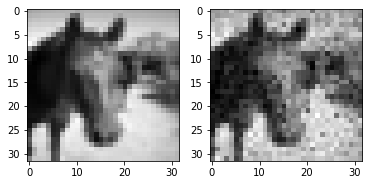

25  :  [0.369626] 25
50  :  [0.369626] 25
75  :  [0.3829883] 25
100  :  [0.3829883] 25
125  :  [0.3829883] 25
150  :  [0.3829883] 25
175  :  [0.3829883] 25
200  :  [0.3829883] 25
225  :  [0.38375375] 25
250  :  [0.38426992] 25
275  :  [0.38426992] 25
300  :  [0.38426992] 25
325  :  [0.38426992] 25
350  :  [0.38426992] 25
375  :  [0.38426992] 25
400  :  [0.38426992] 25
425  :  [0.38426992] 25
450  :  [0.38426992] 25
475  :  [0.38426992] 25
500  :  [0.38426992] 25
525  :  [0.38426992] 25
550  :  [0.38426992] 25
575  :  [0.38426992] 25
600  :  [0.38478747] 25
625  :  [0.38478747] 25
650  :  [0.38478747] 25
675  :  [0.38557708] 25
700  :  [0.38557708] 25
725  :  [0.38557708] 25
750  :  [0.38625625] 25
775  :  [0.38648823] 25
800  :  [0.38648823] 25
825  :  [0.38648823] 25
NOT IMPROVING!  850  :  [0.3866601] 25
Time:  214.49958658218384  seconds
Predicted class:  [2]


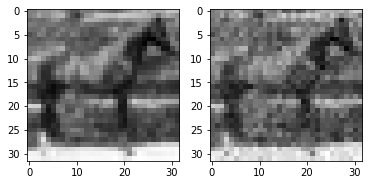

25  :  [0.33649087] 25
50  :  [0.33649087] 25
75  :  [0.34714478] 25
100  :  [0.34792644] 25
125  :  [0.34935153] 25
150  :  [0.34834504] 25
175  :  [0.36480394] 25
200  :  [0.36479232] 25
225  :  [0.36479232] 25
250  :  [0.36479232] 25
275  :  [0.36479232] 25
300  :  [0.36479232] 25
325  :  [0.36479232] 25
350  :  [0.36479232] 25
375  :  [0.36479232] 25
400  :  [0.36479232] 25
425  :  [0.36479232] 25
450  :  [0.3661052] 25
475  :  [0.36649844] 25
500  :  [0.3669474] 25
525  :  [0.3669474] 25
550  :  [0.3676079] 25
575  :  [0.3686186] 25
600  :  [0.3686186] 25
625  :  [0.36899394] 25
650  :  [0.36955118] 25
675  :  [0.36991453] 25
700  :  [0.37062633] 25
725  :  [0.37065858] 25
750  :  [0.37065858] 25
775  :  [0.37081033] 25
800  :  [0.37081033] 25
825  :  [0.37092525] 25
850  :  [0.370958] 25
875  :  [0.37113845] 25
900  :  [0.37113845] 25
925  :  [0.37122142] 25
950  :  [0.37124458] 25
975  :  [0.3714593] 25
1000  :  [0.3714593] 25
1025  :  [0.37151182] 25
1050  :  [0.3715427] 25
107

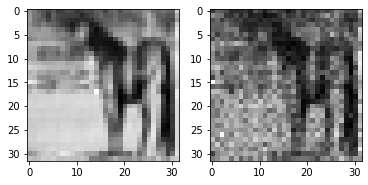

25  :  [0.27595615] 25
50  :  [0.29170835] 25
75  :  [0.29238614] 25
100  :  [0.2930806] 25
125  :  [0.29244673] 25
150  :  [0.29478404] 25
175  :  [0.3046231] 25
200  :  [0.3056363] 25
225  :  [0.30647376] 25
250  :  [0.30647376] 25
275  :  [0.30647376] 25
300  :  [0.30647376] 25
325  :  [0.30647376] 25
350  :  [0.30669004] 25
375  :  [0.30669004] 25
400  :  [0.30670473] 25
425  :  [0.3077579] 25
450  :  [0.30940628] 25
475  :  [0.31158826] 25
500  :  [0.31155348] 25
525  :  [0.31187367] 25
550  :  [0.31274027] 25
575  :  [0.31274027] 25
600  :  [0.31274027] 25
625  :  [0.31287438] 25
650  :  [0.3129322] 25
675  :  [0.31441575] 25
700  :  [0.31441575] 25
725  :  [0.31441575] 25
750  :  [0.31458452] 25
775  :  [0.31477997] 25
800  :  [0.3152744] 25
825  :  [0.31587753] 25
850  :  [0.31587753] 25
875  :  [0.31589204] 25
900  :  [0.31599024] 25
925  :  [0.31599024] 25
950  :  [0.3161041] 25
975  :  [0.31615084] 25
1000  :  [0.31625143] 25
1025  :  [0.3163666] 25
1050  :  [0.31638017] 25


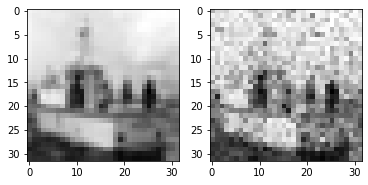

In [0]:
de_npc = DE_NPC(param_dict)
times = []
nfes = []
psnrs = []
predicted_classes = []
for adv_ind in range(adversarial.shape[0]):
  de_npc.change_input(adversarial[adv_ind].reshape((32*32,1)),adversarial_y[adv_ind],32*32)
  timed, nfed = de_npc.execute(model)
  times.append(timed)
  nfes.append(nfed)
## increasing coefficient of the first term in fitness function and
## increasing the standard deviation of the noise increases the chance
## to find an adversarial example but it decreases the image quality
## of the adversarial example found
## also this algorithm can discard the best individual in the next generation
## to prevent this we can put it to population[0] after shuffling
  adv = np.clip(de_npc.X_best, 0, 255)
  psnrs.append(PSNR(adversarial[adv_ind],adv))
  preds_adv = model.predict(adv.reshape(1,32,32,1) / 255.0)
  predicted_classes.extend(np.argmax(preds_adv,axis=1))
  print("Predicted class: ",np.argmax(preds_adv,axis=1))
  fig = plt.figure()
  ax1 = fig.add_subplot(1,2,1)
  ax1.imshow(adversarial[adv_ind].reshape(32,32),cmap="gray")
  ax2 = fig.add_subplot(1,2,2)
  ax2.imshow(de_npc.X_best.reshape(32,32),cmap="gray")
  plt.show()
  adversarial[adv_ind] = de_npc.X_best.reshape((32,32,1))

airplane										
automobile										
bird										
cat										
deer										
dog										
frog										
horse										
ship										
truck

In [1]:
file_ = open('adv_de_cnn_cifar', 'wb')
pickle.dump(adversarial, file_)
pickle.dump(times, file_)
pickle.dump(nfes , file_)
pickle.dump(psnrs , file_)
pickle.dump(predicted_classes, file_)
file_.close()

NameError: ignored

In [0]:
print(np.max(times))
print(np.min(times))
print(np.mean(times))
print(np.std(times))

In [0]:
print(np.max(nfes))
print(np.min(nfes))
print(np.mean(nfes))
print(np.std(nfes))

In [0]:
print(np.max(psnrs))
print(np.min(psnrs))
print(np.mean(psnrs))
print(np.std(psnrs))